# Syn vs Nonsyn and Non-nonsense vs Nonsense mutation rates

## Based on positions, instead of codons!

This makes it easier to use these for FDR estimation.

In [3]:
%run "Header.ipynb"
%run "GeneUtils.ipynb"

In [61]:
import time
import json
import pickle
import skbio
import pileup
from collections import defaultdict
from parse_sco import parse_sco

In [5]:
seq2pos2pileup = pileup.load()

## Percentages (values of $p$) for naive mutation calling

### Values we use for plotting
Currently the same as in the codon mutation notebook. I guess these should be a shared variable, ideally? But that might be too much work for its own good.

In [6]:
percentages = [2, 1, 0.5, 0.25, 0.15]

### Full values, used for plotting a FDR curve elsewhere

Copied from the target/decoy notebook. may be nice to generalize to shared code too i guess

In [7]:
# Percentages go from 4.99%, 4.98%, ..., 0.16%, 0.15%
full_percentages = [p / 100 for p in range(15, 500, 1)][::-1]
print(f"First two percentages: {full_percentages[:2]}")
print(f"Last two percentages: {full_percentages[-2:]}")
print(f"Number of percentages: {len(full_percentages):,}")

First two percentages: [4.99, 4.98]
Last two percentages: [0.16, 0.15]
Number of percentages: 485


In [8]:
# Sanity check -- we can just compute this data for all of the stuff in full_percentages
# and then for the stuff we wanna plot in this notebook just focus on the values in percentages
for p in percentages:
    assert p in full_percentages, f"{p}% not in full_percentages"

## Compute possible (non)synonymous and (non)nonsense mutations, in general

Not specific to a given MAG -- just in the context of all possible codons, using the standard genetic code.

In [9]:
codons = []
dna = "ACGT"
for x in dna:
    for y in dna:
        for z in dna:
            codons.append(x+y+z)
            
# Maps the 64 codons --> [1, 2, 3] --> an integer 0, 1, 2, or 3, indicating how many of the 3 mutations
# from this CP in this codon into another nucleotide are synonymous (si) or nonsynonymous (ni)
codon2cp2si = defaultdict(dict)
codon2cp2ni = defaultdict(dict)

# Like above, but for non-nonsense (nnsi) or nonsense (nsi) mutations and only for the 61 sense codons
codon2cp2nnsi = defaultdict(dict)
codon2cp2nsi = defaultdict(dict)

stop_codons = []

for c in codons:
    is_not_stop = not (str(skbio.DNA(c).translate()) == "*")
    if not is_not_stop:
        stop_codons.append(c)
    for pos in [0, 1, 2]:
        si = 0
        ni = 0
        nnsi = 0
        nsi = 0
        for alt_nt in set(dna) - set(c[pos]):
            alt_codon = c[:pos] + alt_nt + c[pos + 1:]
            aa1 = str(skbio.DNA(c).translate())
            aa2 = str(skbio.DNA(alt_codon).translate())
            if aa1 == aa2:
                si += 1
                if is_not_stop:
                    nnsi += 1
            else:
                ni += 1
                if is_not_stop:
                    if aa2 == "*":
                        nsi += 1
                    else:
                        nnsi += 1
                    
        assert si + ni == 3
        codon2cp2si[c][pos + 1] = si
        codon2cp2ni[c][pos + 1] = ni
        
        if is_not_stop:
            assert nsi + nnsi == 3
            codon2cp2nnsi[c][pos + 1] = nnsi
            codon2cp2nsi[c][pos + 1] = nsi
            
assert len(codon2cp2si) == len(codon2cp2ni) == 64
assert len(codon2cp2nnsi) == len(codon2cp2nsi) == 61
assert len(stop_codons) == 3

## Use these numbers to compute $\sum_i S_i$ (and $N_i$, $NNS_i$, $NS_i$) for all MAGs

In [62]:
# seq --> list of 1-indexed positions where a mutation here can be nonsyn or nonsense
seq2poss_nonsyn_positions = {}
seq2poss_nonsense_positions = {}

# Total poss numbers of single-nucleotide (non)synonymous and (non)nonsense mutations throughout the genomes
seq2poss_si = defaultdict(int)
seq2poss_ni = defaultdict(int)
seq2poss_nnsi = defaultdict(int)
seq2poss_nsi = defaultdict(int)

# Defined the same as in the earlier codon-based S/N notebook.
p2seq2obs_si = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_ni = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nnsi = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nsi = {p: defaultdict(int) for p in full_percentages}

# For debugging... I don't recommend using this otherwise due to how much gets printed out!
verbose = False

t0 = time.time()
for seq in SEQS:
    print(f"On {seq}. Runtime: {time.time() - t0:,.2f} sec.")
    df = parse_sco(f"../seqs/genes/{seq}.sco")
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    # Figure out quickly which positions are in multiple genes, so we can ignore them
    pos_to_genes = get_parent_gene_info_of_many_positions(df)
    
    poss_nonsyn_pos = []
    poss_nonsense_pos = []
    
    for gene in df.itertuples():
        t0g = time.time()
        print(
            f"{seq2name[seq]}: On gene {gene.Index:,} / {len(df.index):,}. "
            f"So far {len(poss_nonsyn_pos):,} poss nonsyn and {len(poss_nonsense_pos):,} "
            f"poss nonsense positions. Runtime: {time.time() - t0:,.2f} sec."
        )
        # The order of positions we go through is dependent on gene orientation:
        # left --> right if this is a "+" strand gene,
        # right --> left if this is a "-" strand gene.
        pos_interval = get_pos_interval_from_gene(gene)
        
        # We'll update these values as we walk through the gene.
        # curr_codon_cp1_pos indicates CP1 (the left end for + genes, the right end for - genes)
        # of the current gene. It's 1-indexed, along with the gene coordinates.
        curr_codon_cp1_pos = pos_interval[0]
        # Always either 1, 2, or 3
        cp = 1
        
        for pos in pos_interval:
            if verbose: print(f"On position {pos:,} (CP {cp}) ")
            if cp == 1:
                # It's easier to sync this at the top rather than bottom of the loop because the positions
                # in pos_interval could be increasing or decreasing depending on the gene's strand
                curr_codon_cp1_pos = pos
            
            # We don't attempt mutation calling at multi-gene positions, or at
            # unreasonable (ref != consensus) positions.
            
            # ... And now we actually naively try to call a mutation at this position (trying lots of
            # values of p at once so we can create an FDR curve, barplots, etc).
            pos_pileup = seq2pos2pileup[seq][pos]
            
            if len(pos_to_genes[pos]) == 1 and pileup.is_reasonable(pos_pileup):
                
                if verbose: print("\tReasonable and in just 1 gene ", end="")
                    
                if gene.Strand == "+":
                    # The skbio sequence is 0-indexed, so we gotta subtract by 1
                    parent_codon_fasta = fasta[curr_codon_cp1_pos - 1: curr_codon_cp1_pos + 2]
                    if verbose:
                        print(f"(+); parent codon is {parent_codon_fasta}")
                    
                elif gene.Strand == "-":
                    parent_codon_fwd_fasta = fasta[curr_codon_cp1_pos - 3: curr_codon_cp1_pos]
                    parent_codon_fwd_str = str(parent_codon_fwd_fasta)
                    parent_codon_fasta = parent_codon_fwd_fasta.reverse_complement()
                    if verbose:
                        print(
                            f"(-); parent codon (not RC'd) is {parent_codon_fwd_fasta}; "
                            f"RC'd, it's {parent_codon_fasta} ({parent_codon_fasta.translate()})"
                        )
                
                else:
                    raise ValueError(f"Invalid strand: {gene.Strand}")
                
                parent_codon_str = str(parent_codon_fasta)
                
                # Update possible Si|Ni and NNSi|NSi values based on this position and its parent codon.
                seq2poss_si[seq] += codon2cp2si[parent_codon_str][cp]
                seq2poss_ni[seq] += codon2cp2ni[parent_codon_str][cp]
                if codon2cp2ni[parent_codon_str][cp] > 0:
                    poss_nonsyn_pos.append(pos)
                    
                if verbose:
                    print(
                        f"\tSi = {codon2cp2si[parent_codon_str][cp]}, "
                        f"Ni = {codon2cp2ni[parent_codon_str][cp]}"
                    )
                    
                in_sense_codon = (parent_codon_str not in stop_codons)
                if in_sense_codon:
                    seq2poss_nnsi[seq] += codon2cp2nnsi[parent_codon_str][cp]
                    seq2poss_nsi[seq] += codon2cp2nsi[parent_codon_str][cp]
                    
                    if codon2cp2nsi[parent_codon_str][cp] > 0:
                        poss_nonsense_pos.append(pos)
                        
                    if verbose:
                        print(
                            f"\tPosition is in a sense codon, and "
                            f"NNSi = {codon2cp2nnsi[parent_codon_str][cp]}, "
                            f"NSi = {codon2cp2nsi[parent_codon_str][cp]}"
                        )
                
                # Since we currently define mutations as a binary thing (either a position is mutated
                # or it isn't), we can precompute the step of figuring out the mutated codon resulting from
                # a position being called a mutation -- and we can thus figure out in advance if this position
                # will be a (non)synonymous or (non)nonsense mutation, before actually calling it a mutation
                # (...should save some time).

                if pileup.any_mismatches(pos_pileup):
                    alt_nt = pileup.get_alt_nt_if_reasonable(pos_pileup)

                    if verbose: print(f"\tPosition has mismatches; max freq alt nt is {alt_nt}")

                    # if alt_nt is None, it means this position was unreasonable -- but we've already
                    # verified above that this position is reasonable!
                    assert alt_nt is not None

                    # Construct a "mutated" version of this position's parent codon, with just this
                    # alternate nucleotide changed. This doesn't take into account the possibility
                    # of other positions within this codon being mutated, which is a notable limitation
                    # of this approach.
                    if gene.Strand == "+":
                        mutated_parent_codon = parent_codon_fasta.replace([cp - 1], alt_nt)
                    else:
                        # Do two things: 1) convert from a reverse-direction CP to a fwd-direction CP,
                        # and 2) switch to using 0-indexing so we can work with skbio.DNA objects.
                        if cp == 1: idx_to_replace = 2
                        elif cp == 2: idx_to_replace = 1
                        else: idx_to_replace = 0

                        # Apply the mutation, *then* reverse-complement the codon
                        mutated_parent_codon_fwd = parent_codon_fwd_fasta.replace([idx_to_replace], alt_nt)
                        mutated_parent_codon = mutated_parent_codon_fwd.reverse_complement()
                
                    aa1 = str(parent_codon_fasta.translate())
                    aa2 = str(mutated_parent_codon.translate())
                    
                    is_syn = (aa1 == aa2)
                    aa2_is_stop = (aa2 == "*")
                    
                    if verbose:
                        print(f"\tAlt codon is {mutated_parent_codon} ({aa2}); is syn? {is_syn}")
                    
                    # We don't go through this step if pileup.any_mismatches() is False! Because... in that
                    # case, this position can never be a p-mutation. So we can save a lot of time.
                    for p in full_percentages:

                        if pileup.naively_call_mutation(pos_pileup, p, only_call_if_rare=True):
                            if verbose:
                                print(f"\tIs (rare) mut at p = {p}!")
                            if is_syn:
                                p2seq2obs_si[p][seq] += 1
                            else:
                                p2seq2obs_ni[p][seq] += 1

                            if in_sense_codon:
                                if aa2_is_stop:
                                    p2seq2obs_nsi[p][seq] += 1
                                else:
                                    p2seq2obs_nnsi[p][seq] += 1
                        
            cp = next_cp(cp)
    
    seq2poss_nonsyn_positions[seq] = poss_nonsyn_pos
    seq2poss_nonsense_positions[seq] = poss_nonsense_pos
    
print(f"Done. Runtime: {time.time() - t0:,.2f} sec.")

On edge_6104. Runtime: 0.00 sec.
CAMP: On gene 1 / 1,297. So far 0 poss nonsyn and 0 poss nonsense positions. Runtime: 0.48 sec.
CAMP: On gene 2 / 1,297. So far 400 poss nonsyn and 58 poss nonsense positions. Runtime: 0.80 sec.
CAMP: On gene 3 / 1,297. So far 736 poss nonsyn and 113 poss nonsense positions. Runtime: 1.06 sec.
CAMP: On gene 4 / 1,297. So far 1,126 poss nonsyn and 168 poss nonsense positions. Runtime: 1.39 sec.
CAMP: On gene 5 / 1,297. So far 2,283 poss nonsyn and 315 poss nonsense positions. Runtime: 2.29 sec.
CAMP: On gene 6 / 1,297. So far 2,516 poss nonsyn and 349 poss nonsense positions. Runtime: 2.47 sec.
CAMP: On gene 7 / 1,297. So far 3,450 poss nonsyn and 472 poss nonsense positions. Runtime: 3.12 sec.
CAMP: On gene 8 / 1,297. So far 3,936 poss nonsyn and 525 poss nonsense positions. Runtime: 3.48 sec.
CAMP: On gene 9 / 1,297. So far 4,625 poss nonsyn and 618 poss nonsense positions. Runtime: 3.96 sec.
CAMP: On gene 10 / 1,297. So far 5,076 poss nonsyn and 679 p

CAMP: On gene 78 / 1,297. So far 59,465 poss nonsyn and 7,682 poss nonsense positions. Runtime: 43.91 sec.
CAMP: On gene 79 / 1,297. So far 59,789 poss nonsyn and 7,732 poss nonsense positions. Runtime: 44.11 sec.
CAMP: On gene 80 / 1,297. So far 60,168 poss nonsyn and 7,786 poss nonsense positions. Runtime: 44.34 sec.
CAMP: On gene 81 / 1,297. So far 61,062 poss nonsyn and 7,906 poss nonsense positions. Runtime: 44.98 sec.
CAMP: On gene 82 / 1,297. So far 61,515 poss nonsyn and 7,959 poss nonsense positions. Runtime: 45.32 sec.
CAMP: On gene 83 / 1,297. So far 62,415 poss nonsyn and 8,085 poss nonsense positions. Runtime: 45.91 sec.
CAMP: On gene 84 / 1,297. So far 63,213 poss nonsyn and 8,183 poss nonsense positions. Runtime: 46.50 sec.
CAMP: On gene 85 / 1,297. So far 64,151 poss nonsyn and 8,306 poss nonsense positions. Runtime: 47.20 sec.
CAMP: On gene 86 / 1,297. So far 64,802 poss nonsyn and 8,400 poss nonsense positions. Runtime: 47.64 sec.
CAMP: On gene 87 / 1,297. So far 65,2

CAMP: On gene 154 / 1,297. So far 116,984 poss nonsyn and 14,919 poss nonsense positions. Runtime: 78.95 sec.
CAMP: On gene 155 / 1,297. So far 117,463 poss nonsyn and 14,968 poss nonsense positions. Runtime: 79.29 sec.
CAMP: On gene 156 / 1,297. So far 118,460 poss nonsyn and 15,097 poss nonsense positions. Runtime: 79.99 sec.
CAMP: On gene 157 / 1,297. So far 119,391 poss nonsyn and 15,212 poss nonsense positions. Runtime: 80.64 sec.
CAMP: On gene 158 / 1,297. So far 119,568 poss nonsyn and 15,232 poss nonsense positions. Runtime: 80.75 sec.
CAMP: On gene 159 / 1,297. So far 120,999 poss nonsyn and 15,433 poss nonsense positions. Runtime: 81.76 sec.
CAMP: On gene 160 / 1,297. So far 122,026 poss nonsyn and 15,547 poss nonsense positions. Runtime: 82.48 sec.
CAMP: On gene 161 / 1,297. So far 123,028 poss nonsyn and 15,676 poss nonsense positions. Runtime: 83.24 sec.
CAMP: On gene 162 / 1,297. So far 123,291 poss nonsyn and 15,708 poss nonsense positions. Runtime: 83.39 sec.
CAMP: On g

CAMP: On gene 229 / 1,297. So far 180,456 poss nonsyn and 22,935 poss nonsense positions. Runtime: 123.30 sec.
CAMP: On gene 230 / 1,297. So far 181,257 poss nonsyn and 23,061 poss nonsense positions. Runtime: 123.82 sec.
CAMP: On gene 231 / 1,297. So far 182,409 poss nonsyn and 23,201 poss nonsense positions. Runtime: 124.53 sec.
CAMP: On gene 232 / 1,297. So far 184,307 poss nonsyn and 23,426 poss nonsense positions. Runtime: 125.70 sec.
CAMP: On gene 233 / 1,297. So far 184,961 poss nonsyn and 23,518 poss nonsense positions. Runtime: 126.12 sec.
CAMP: On gene 234 / 1,297. So far 186,303 poss nonsyn and 23,661 poss nonsense positions. Runtime: 127.01 sec.
CAMP: On gene 235 / 1,297. So far 187,697 poss nonsyn and 23,829 poss nonsense positions. Runtime: 127.88 sec.
CAMP: On gene 236 / 1,297. So far 188,045 poss nonsyn and 23,873 poss nonsense positions. Runtime: 128.11 sec.
CAMP: On gene 237 / 1,297. So far 190,101 poss nonsyn and 24,100 poss nonsense positions. Runtime: 129.39 sec.
C

CAMP: On gene 303 / 1,297. So far 247,521 poss nonsyn and 31,454 poss nonsense positions. Runtime: 168.43 sec.
CAMP: On gene 304 / 1,297. So far 248,638 poss nonsyn and 31,580 poss nonsense positions. Runtime: 169.16 sec.
CAMP: On gene 305 / 1,297. So far 250,371 poss nonsyn and 31,839 poss nonsense positions. Runtime: 170.25 sec.
CAMP: On gene 306 / 1,297. So far 251,558 poss nonsyn and 31,956 poss nonsense positions. Runtime: 170.99 sec.
CAMP: On gene 307 / 1,297. So far 252,600 poss nonsyn and 32,080 poss nonsense positions. Runtime: 171.67 sec.
CAMP: On gene 308 / 1,297. So far 253,300 poss nonsyn and 32,183 poss nonsense positions. Runtime: 172.11 sec.
CAMP: On gene 309 / 1,297. So far 253,716 poss nonsyn and 32,230 poss nonsense positions. Runtime: 172.38 sec.
CAMP: On gene 310 / 1,297. So far 254,069 poss nonsyn and 32,278 poss nonsense positions. Runtime: 172.63 sec.
CAMP: On gene 311 / 1,297. So far 255,078 poss nonsyn and 32,390 poss nonsense positions. Runtime: 173.36 sec.
C

CAMP: On gene 378 / 1,297. So far 315,109 poss nonsyn and 40,061 poss nonsense positions. Runtime: 211.54 sec.
CAMP: On gene 379 / 1,297. So far 315,888 poss nonsyn and 40,156 poss nonsense positions. Runtime: 212.01 sec.
CAMP: On gene 380 / 1,297. So far 317,005 poss nonsyn and 40,296 poss nonsense positions. Runtime: 212.70 sec.
CAMP: On gene 381 / 1,297. So far 318,505 poss nonsyn and 40,495 poss nonsense positions. Runtime: 213.63 sec.
CAMP: On gene 382 / 1,297. So far 318,870 poss nonsyn and 40,536 poss nonsense positions. Runtime: 213.89 sec.
CAMP: On gene 383 / 1,297. So far 319,669 poss nonsyn and 40,635 poss nonsense positions. Runtime: 214.36 sec.
CAMP: On gene 384 / 1,297. So far 322,354 poss nonsyn and 40,981 poss nonsense positions. Runtime: 216.05 sec.
CAMP: On gene 385 / 1,297. So far 322,723 poss nonsyn and 41,032 poss nonsense positions. Runtime: 216.27 sec.
CAMP: On gene 386 / 1,297. So far 324,893 poss nonsyn and 41,284 poss nonsense positions. Runtime: 217.49 sec.
C

CAMP: On gene 452 / 1,297. So far 377,967 poss nonsyn and 48,014 poss nonsense positions. Runtime: 252.20 sec.
CAMP: On gene 453 / 1,297. So far 378,290 poss nonsyn and 48,066 poss nonsense positions. Runtime: 252.39 sec.
CAMP: On gene 454 / 1,297. So far 379,760 poss nonsyn and 48,237 poss nonsense positions. Runtime: 253.26 sec.
CAMP: On gene 455 / 1,297. So far 380,995 poss nonsyn and 48,376 poss nonsense positions. Runtime: 254.05 sec.
CAMP: On gene 456 / 1,297. So far 381,651 poss nonsyn and 48,450 poss nonsense positions. Runtime: 254.50 sec.
CAMP: On gene 457 / 1,297. So far 382,228 poss nonsyn and 48,504 poss nonsense positions. Runtime: 254.89 sec.
CAMP: On gene 458 / 1,297. So far 382,710 poss nonsyn and 48,561 poss nonsense positions. Runtime: 255.20 sec.
CAMP: On gene 459 / 1,297. So far 383,968 poss nonsyn and 48,736 poss nonsense positions. Runtime: 255.94 sec.
CAMP: On gene 460 / 1,297. So far 384,737 poss nonsyn and 48,836 poss nonsense positions. Runtime: 256.40 sec.
C

CAMP: On gene 526 / 1,297. So far 438,092 poss nonsyn and 55,635 poss nonsense positions. Runtime: 291.16 sec.
CAMP: On gene 527 / 1,297. So far 438,483 poss nonsyn and 55,677 poss nonsense positions. Runtime: 291.42 sec.
CAMP: On gene 528 / 1,297. So far 440,023 poss nonsyn and 55,898 poss nonsense positions. Runtime: 292.50 sec.
CAMP: On gene 529 / 1,297. So far 441,057 poss nonsyn and 55,994 poss nonsense positions. Runtime: 293.28 sec.
CAMP: On gene 530 / 1,297. So far 442,100 poss nonsyn and 56,117 poss nonsense positions. Runtime: 293.91 sec.
CAMP: On gene 531 / 1,297. So far 443,655 poss nonsyn and 56,308 poss nonsense positions. Runtime: 294.95 sec.
CAMP: On gene 532 / 1,297. So far 443,996 poss nonsyn and 56,347 poss nonsense positions. Runtime: 295.14 sec.
CAMP: On gene 533 / 1,297. So far 444,267 poss nonsyn and 56,390 poss nonsense positions. Runtime: 295.32 sec.
CAMP: On gene 534 / 1,297. So far 444,819 poss nonsyn and 56,450 poss nonsense positions. Runtime: 295.65 sec.
C

CAMP: On gene 600 / 1,297. So far 496,130 poss nonsyn and 62,917 poss nonsense positions. Runtime: 328.90 sec.
CAMP: On gene 601 / 1,297. So far 496,557 poss nonsyn and 62,969 poss nonsense positions. Runtime: 329.16 sec.
CAMP: On gene 602 / 1,297. So far 497,080 poss nonsyn and 63,034 poss nonsense positions. Runtime: 329.54 sec.
CAMP: On gene 603 / 1,297. So far 497,720 poss nonsyn and 63,102 poss nonsense positions. Runtime: 329.95 sec.
CAMP: On gene 604 / 1,297. So far 498,719 poss nonsyn and 63,216 poss nonsense positions. Runtime: 330.57 sec.
CAMP: On gene 605 / 1,297. So far 499,561 poss nonsyn and 63,317 poss nonsense positions. Runtime: 331.13 sec.
CAMP: On gene 606 / 1,297. So far 500,299 poss nonsyn and 63,398 poss nonsense positions. Runtime: 331.61 sec.
CAMP: On gene 607 / 1,297. So far 501,827 poss nonsyn and 63,597 poss nonsense positions. Runtime: 332.59 sec.
CAMP: On gene 608 / 1,297. So far 502,459 poss nonsyn and 63,672 poss nonsense positions. Runtime: 332.98 sec.
C

CAMP: On gene 674 / 1,297. So far 556,864 poss nonsyn and 70,563 poss nonsense positions. Runtime: 368.69 sec.
CAMP: On gene 675 / 1,297. So far 557,261 poss nonsyn and 70,612 poss nonsense positions. Runtime: 368.96 sec.
CAMP: On gene 676 / 1,297. So far 557,804 poss nonsyn and 70,679 poss nonsense positions. Runtime: 369.35 sec.
CAMP: On gene 677 / 1,297. So far 558,059 poss nonsyn and 70,715 poss nonsense positions. Runtime: 369.53 sec.
CAMP: On gene 678 / 1,297. So far 559,929 poss nonsyn and 70,944 poss nonsense positions. Runtime: 370.76 sec.
CAMP: On gene 679 / 1,297. So far 560,525 poss nonsyn and 71,017 poss nonsense positions. Runtime: 371.18 sec.
CAMP: On gene 680 / 1,297. So far 560,915 poss nonsyn and 71,060 poss nonsense positions. Runtime: 371.41 sec.
CAMP: On gene 681 / 1,297. So far 561,346 poss nonsyn and 71,105 poss nonsense positions. Runtime: 371.69 sec.
CAMP: On gene 682 / 1,297. So far 561,602 poss nonsyn and 71,136 poss nonsense positions. Runtime: 371.87 sec.
C

CAMP: On gene 748 / 1,297. So far 614,310 poss nonsyn and 77,981 poss nonsense positions. Runtime: 404.99 sec.
CAMP: On gene 749 / 1,297. So far 615,134 poss nonsyn and 78,072 poss nonsense positions. Runtime: 405.54 sec.
CAMP: On gene 750 / 1,297. So far 615,539 poss nonsyn and 78,126 poss nonsense positions. Runtime: 405.80 sec.
CAMP: On gene 751 / 1,297. So far 616,995 poss nonsyn and 78,313 poss nonsense positions. Runtime: 406.76 sec.
CAMP: On gene 752 / 1,297. So far 617,227 poss nonsyn and 78,335 poss nonsense positions. Runtime: 406.94 sec.
CAMP: On gene 753 / 1,297. So far 618,379 poss nonsyn and 78,498 poss nonsense positions. Runtime: 407.67 sec.
CAMP: On gene 754 / 1,297. So far 618,978 poss nonsyn and 78,578 poss nonsense positions. Runtime: 408.08 sec.
CAMP: On gene 755 / 1,297. So far 620,198 poss nonsyn and 78,728 poss nonsense positions. Runtime: 408.91 sec.
CAMP: On gene 756 / 1,297. So far 620,908 poss nonsyn and 78,807 poss nonsense positions. Runtime: 409.33 sec.
C

CAMP: On gene 823 / 1,297. So far 671,877 poss nonsyn and 85,511 poss nonsense positions. Runtime: 443.27 sec.
CAMP: On gene 824 / 1,297. So far 673,182 poss nonsyn and 85,700 poss nonsense positions. Runtime: 444.18 sec.
CAMP: On gene 825 / 1,297. So far 673,622 poss nonsyn and 85,758 poss nonsense positions. Runtime: 444.52 sec.
CAMP: On gene 826 / 1,297. So far 674,568 poss nonsyn and 85,893 poss nonsense positions. Runtime: 445.19 sec.
CAMP: On gene 827 / 1,297. So far 674,873 poss nonsyn and 85,935 poss nonsense positions. Runtime: 445.39 sec.
CAMP: On gene 828 / 1,297. So far 675,760 poss nonsyn and 86,058 poss nonsense positions. Runtime: 445.92 sec.
CAMP: On gene 829 / 1,297. So far 676,053 poss nonsyn and 86,096 poss nonsense positions. Runtime: 446.11 sec.
CAMP: On gene 830 / 1,297. So far 677,193 poss nonsyn and 86,234 poss nonsense positions. Runtime: 446.89 sec.
CAMP: On gene 831 / 1,297. So far 677,894 poss nonsyn and 86,331 poss nonsense positions. Runtime: 447.36 sec.
C

CAMP: On gene 897 / 1,297. So far 733,170 poss nonsyn and 93,259 poss nonsense positions. Runtime: 483.83 sec.
CAMP: On gene 898 / 1,297. So far 734,116 poss nonsyn and 93,377 poss nonsense positions. Runtime: 484.55 sec.
CAMP: On gene 899 / 1,297. So far 735,238 poss nonsyn and 93,499 poss nonsense positions. Runtime: 485.35 sec.
CAMP: On gene 900 / 1,297. So far 735,756 poss nonsyn and 93,569 poss nonsense positions. Runtime: 485.74 sec.
CAMP: On gene 901 / 1,297. So far 736,824 poss nonsyn and 93,682 poss nonsense positions. Runtime: 486.47 sec.
CAMP: On gene 902 / 1,297. So far 737,841 poss nonsyn and 93,787 poss nonsense positions. Runtime: 487.15 sec.
CAMP: On gene 903 / 1,297. So far 738,673 poss nonsyn and 93,902 poss nonsense positions. Runtime: 487.79 sec.
CAMP: On gene 904 / 1,297. So far 740,315 poss nonsyn and 94,132 poss nonsense positions. Runtime: 488.82 sec.
CAMP: On gene 905 / 1,297. So far 741,066 poss nonsyn and 94,225 poss nonsense positions. Runtime: 489.30 sec.
C

CAMP: On gene 971 / 1,297. So far 801,951 poss nonsyn and 101,884 poss nonsense positions. Runtime: 530.73 sec.
CAMP: On gene 972 / 1,297. So far 802,470 poss nonsyn and 101,954 poss nonsense positions. Runtime: 531.08 sec.
CAMP: On gene 973 / 1,297. So far 803,236 poss nonsyn and 102,047 poss nonsense positions. Runtime: 531.55 sec.
CAMP: On gene 974 / 1,297. So far 803,870 poss nonsyn and 102,115 poss nonsense positions. Runtime: 531.97 sec.
CAMP: On gene 975 / 1,297. So far 804,804 poss nonsyn and 102,218 poss nonsense positions. Runtime: 532.56 sec.
CAMP: On gene 976 / 1,297. So far 805,700 poss nonsyn and 102,310 poss nonsense positions. Runtime: 533.23 sec.
CAMP: On gene 977 / 1,297. So far 806,580 poss nonsyn and 102,410 poss nonsense positions. Runtime: 533.79 sec.
CAMP: On gene 978 / 1,297. So far 806,846 poss nonsyn and 102,450 poss nonsense positions. Runtime: 533.97 sec.
CAMP: On gene 979 / 1,297. So far 807,523 poss nonsyn and 102,532 poss nonsense positions. Runtime: 534.

CAMP: On gene 1,044 / 1,297. So far 844,763 poss nonsyn and 107,491 poss nonsense positions. Runtime: 565.16 sec.
CAMP: On gene 1,045 / 1,297. So far 845,293 poss nonsyn and 107,566 poss nonsense positions. Runtime: 565.59 sec.
CAMP: On gene 1,046 / 1,297. So far 845,752 poss nonsyn and 107,626 poss nonsense positions. Runtime: 566.06 sec.
CAMP: On gene 1,047 / 1,297. So far 846,845 poss nonsyn and 107,760 poss nonsense positions. Runtime: 567.04 sec.
CAMP: On gene 1,048 / 1,297. So far 850,386 poss nonsyn and 108,233 poss nonsense positions. Runtime: 569.95 sec.
CAMP: On gene 1,049 / 1,297. So far 850,592 poss nonsyn and 108,268 poss nonsense positions. Runtime: 570.09 sec.
CAMP: On gene 1,050 / 1,297. So far 851,044 poss nonsyn and 108,319 poss nonsense positions. Runtime: 570.47 sec.
CAMP: On gene 1,051 / 1,297. So far 851,693 poss nonsyn and 108,415 poss nonsense positions. Runtime: 571.13 sec.
CAMP: On gene 1,052 / 1,297. So far 852,980 poss nonsyn and 108,561 poss nonsense positi

CAMP: On gene 1,116 / 1,297. So far 910,907 poss nonsyn and 115,843 poss nonsense positions. Runtime: 624.08 sec.
CAMP: On gene 1,117 / 1,297. So far 911,300 poss nonsyn and 115,895 poss nonsense positions. Runtime: 624.38 sec.
CAMP: On gene 1,118 / 1,297. So far 912,097 poss nonsyn and 116,008 poss nonsense positions. Runtime: 624.91 sec.
CAMP: On gene 1,119 / 1,297. So far 912,664 poss nonsyn and 116,078 poss nonsense positions. Runtime: 625.32 sec.
CAMP: On gene 1,120 / 1,297. So far 913,382 poss nonsyn and 116,168 poss nonsense positions. Runtime: 625.81 sec.
CAMP: On gene 1,121 / 1,297. So far 913,790 poss nonsyn and 116,219 poss nonsense positions. Runtime: 626.10 sec.
CAMP: On gene 1,122 / 1,297. So far 914,178 poss nonsyn and 116,267 poss nonsense positions. Runtime: 626.37 sec.
CAMP: On gene 1,123 / 1,297. So far 914,834 poss nonsyn and 116,350 poss nonsense positions. Runtime: 626.84 sec.
CAMP: On gene 1,124 / 1,297. So far 915,420 poss nonsyn and 116,424 poss nonsense positi

CAMP: On gene 1,188 / 1,297. So far 960,696 poss nonsyn and 122,073 poss nonsense positions. Runtime: 660.30 sec.
CAMP: On gene 1,189 / 1,297. So far 961,224 poss nonsyn and 122,128 poss nonsense positions. Runtime: 660.71 sec.
CAMP: On gene 1,190 / 1,297. So far 961,732 poss nonsyn and 122,208 poss nonsense positions. Runtime: 661.08 sec.
CAMP: On gene 1,191 / 1,297. So far 962,072 poss nonsyn and 122,262 poss nonsense positions. Runtime: 661.36 sec.
CAMP: On gene 1,192 / 1,297. So far 962,442 poss nonsyn and 122,326 poss nonsense positions. Runtime: 661.62 sec.
CAMP: On gene 1,193 / 1,297. So far 964,060 poss nonsyn and 122,532 poss nonsense positions. Runtime: 662.75 sec.
CAMP: On gene 1,194 / 1,297. So far 964,489 poss nonsyn and 122,576 poss nonsense positions. Runtime: 663.08 sec.
CAMP: On gene 1,195 / 1,297. So far 965,570 poss nonsyn and 122,706 poss nonsense positions. Runtime: 663.86 sec.
CAMP: On gene 1,196 / 1,297. So far 966,453 poss nonsyn and 122,811 poss nonsense positi

CAMP: On gene 1,261 / 1,297. So far 1,016,265 poss nonsyn and 129,044 poss nonsense positions. Runtime: 703.22 sec.
CAMP: On gene 1,262 / 1,297. So far 1,016,703 poss nonsyn and 129,110 poss nonsense positions. Runtime: 703.58 sec.
CAMP: On gene 1,263 / 1,297. So far 1,017,787 poss nonsyn and 129,233 poss nonsense positions. Runtime: 704.57 sec.
CAMP: On gene 1,264 / 1,297. So far 1,019,022 poss nonsyn and 129,406 poss nonsense positions. Runtime: 705.57 sec.
CAMP: On gene 1,265 / 1,297. So far 1,020,073 poss nonsyn and 129,559 poss nonsense positions. Runtime: 706.56 sec.
CAMP: On gene 1,266 / 1,297. So far 1,020,499 poss nonsyn and 129,625 poss nonsense positions. Runtime: 706.95 sec.
CAMP: On gene 1,267 / 1,297. So far 1,021,986 poss nonsyn and 129,808 poss nonsense positions. Runtime: 708.16 sec.
CAMP: On gene 1,268 / 1,297. So far 1,022,413 poss nonsyn and 129,862 poss nonsense positions. Runtime: 708.53 sec.
CAMP: On gene 1,269 / 1,297. So far 1,022,724 poss nonsyn and 129,904 po

BACT1: On gene 37 / 1,761. So far 21,627 poss nonsyn and 3,152 poss nonsense positions. Runtime: 737.67 sec.
BACT1: On gene 38 / 1,761. So far 21,954 poss nonsyn and 3,198 poss nonsense positions. Runtime: 737.80 sec.
BACT1: On gene 39 / 1,761. So far 22,477 poss nonsyn and 3,295 poss nonsense positions. Runtime: 738.01 sec.
BACT1: On gene 40 / 1,761. So far 23,343 poss nonsyn and 3,428 poss nonsense positions. Runtime: 738.30 sec.
BACT1: On gene 41 / 1,761. So far 23,745 poss nonsyn and 3,483 poss nonsense positions. Runtime: 738.43 sec.
BACT1: On gene 42 / 1,761. So far 23,864 poss nonsyn and 3,505 poss nonsense positions. Runtime: 738.48 sec.
BACT1: On gene 43 / 1,761. So far 24,408 poss nonsyn and 3,593 poss nonsense positions. Runtime: 738.73 sec.
BACT1: On gene 44 / 1,761. So far 25,328 poss nonsyn and 3,741 poss nonsense positions. Runtime: 739.07 sec.
BACT1: On gene 45 / 1,761. So far 26,264 poss nonsyn and 3,878 poss nonsense positions. Runtime: 739.41 sec.
BACT1: On gene 46 /

BACT1: On gene 112 / 1,761. So far 81,291 poss nonsyn and 11,559 poss nonsense positions. Runtime: 761.70 sec.
BACT1: On gene 113 / 1,761. So far 82,406 poss nonsyn and 11,704 poss nonsense positions. Runtime: 762.14 sec.
BACT1: On gene 114 / 1,761. So far 83,555 poss nonsyn and 11,864 poss nonsense positions. Runtime: 762.59 sec.
BACT1: On gene 115 / 1,761. So far 85,625 poss nonsyn and 12,132 poss nonsense positions. Runtime: 763.35 sec.
BACT1: On gene 116 / 1,761. So far 86,631 poss nonsyn and 12,277 poss nonsense positions. Runtime: 763.75 sec.
BACT1: On gene 117 / 1,761. So far 87,745 poss nonsyn and 12,427 poss nonsense positions. Runtime: 764.21 sec.
BACT1: On gene 118 / 1,761. So far 88,385 poss nonsyn and 12,486 poss nonsense positions. Runtime: 764.52 sec.
BACT1: On gene 119 / 1,761. So far 88,734 poss nonsyn and 12,528 poss nonsense positions. Runtime: 764.68 sec.
BACT1: On gene 120 / 1,761. So far 88,820 poss nonsyn and 12,537 poss nonsense positions. Runtime: 764.72 sec.
B

BACT1: On gene 186 / 1,761. So far 157,816 poss nonsyn and 22,605 poss nonsense positions. Runtime: 792.13 sec.
BACT1: On gene 187 / 1,761. So far 158,072 poss nonsyn and 22,651 poss nonsense positions. Runtime: 792.20 sec.
BACT1: On gene 188 / 1,761. So far 158,335 poss nonsyn and 22,687 poss nonsense positions. Runtime: 792.28 sec.
BACT1: On gene 189 / 1,761. So far 159,650 poss nonsyn and 22,889 poss nonsense positions. Runtime: 792.68 sec.
BACT1: On gene 190 / 1,761. So far 160,659 poss nonsyn and 23,048 poss nonsense positions. Runtime: 793.00 sec.
BACT1: On gene 191 / 1,761. So far 161,078 poss nonsyn and 23,112 poss nonsense positions. Runtime: 793.13 sec.
BACT1: On gene 192 / 1,761. So far 161,654 poss nonsyn and 23,196 poss nonsense positions. Runtime: 793.36 sec.
BACT1: On gene 193 / 1,761. So far 162,127 poss nonsyn and 23,258 poss nonsense positions. Runtime: 793.59 sec.
BACT1: On gene 194 / 1,761. So far 163,353 poss nonsyn and 23,426 poss nonsense positions. Runtime: 794.

BACT1: On gene 260 / 1,761. So far 219,358 poss nonsyn and 31,434 poss nonsense positions. Runtime: 816.42 sec.
BACT1: On gene 261 / 1,761. So far 219,820 poss nonsyn and 31,499 poss nonsense positions. Runtime: 816.62 sec.
BACT1: On gene 262 / 1,761. So far 220,211 poss nonsyn and 31,553 poss nonsense positions. Runtime: 816.77 sec.
BACT1: On gene 263 / 1,761. So far 221,199 poss nonsyn and 31,725 poss nonsense positions. Runtime: 817.29 sec.
BACT1: On gene 264 / 1,761. So far 222,642 poss nonsyn and 31,896 poss nonsense positions. Runtime: 818.03 sec.
BACT1: On gene 265 / 1,761. So far 223,436 poss nonsyn and 32,021 poss nonsense positions. Runtime: 818.47 sec.
BACT1: On gene 266 / 1,761. So far 223,960 poss nonsyn and 32,090 poss nonsense positions. Runtime: 818.76 sec.
BACT1: On gene 267 / 1,761. So far 225,532 poss nonsyn and 32,274 poss nonsense positions. Runtime: 819.57 sec.
BACT1: On gene 268 / 1,761. So far 226,236 poss nonsyn and 32,382 poss nonsense positions. Runtime: 819.

BACT1: On gene 335 / 1,761. So far 301,137 poss nonsyn and 43,214 poss nonsense positions. Runtime: 849.61 sec.
BACT1: On gene 336 / 1,761. So far 302,123 poss nonsyn and 43,372 poss nonsense positions. Runtime: 849.98 sec.
BACT1: On gene 337 / 1,761. So far 302,899 poss nonsyn and 43,452 poss nonsense positions. Runtime: 850.31 sec.
BACT1: On gene 338 / 1,761. So far 303,141 poss nonsyn and 43,475 poss nonsense positions. Runtime: 850.39 sec.
BACT1: On gene 339 / 1,761. So far 304,026 poss nonsyn and 43,587 poss nonsense positions. Runtime: 850.71 sec.
BACT1: On gene 340 / 1,761. So far 304,741 poss nonsyn and 43,680 poss nonsense positions. Runtime: 851.00 sec.
BACT1: On gene 341 / 1,761. So far 305,691 poss nonsyn and 43,802 poss nonsense positions. Runtime: 851.36 sec.
BACT1: On gene 342 / 1,761. So far 306,060 poss nonsyn and 43,849 poss nonsense positions. Runtime: 851.50 sec.
BACT1: On gene 343 / 1,761. So far 307,073 poss nonsyn and 43,971 poss nonsense positions. Runtime: 851.

BACT1: On gene 409 / 1,761. So far 377,402 poss nonsyn and 53,970 poss nonsense positions. Runtime: 878.86 sec.
BACT1: On gene 410 / 1,761. So far 378,161 poss nonsyn and 54,093 poss nonsense positions. Runtime: 879.15 sec.
BACT1: On gene 411 / 1,761. So far 378,518 poss nonsyn and 54,150 poss nonsense positions. Runtime: 879.28 sec.
BACT1: On gene 412 / 1,761. So far 378,890 poss nonsyn and 54,210 poss nonsense positions. Runtime: 879.42 sec.
BACT1: On gene 413 / 1,761. So far 380,807 poss nonsyn and 54,514 poss nonsense positions. Runtime: 880.26 sec.
BACT1: On gene 414 / 1,761. So far 382,424 poss nonsyn and 54,740 poss nonsense positions. Runtime: 880.94 sec.
BACT1: On gene 415 / 1,761. So far 386,212 poss nonsyn and 55,312 poss nonsense positions. Runtime: 882.46 sec.
BACT1: On gene 416 / 1,761. So far 386,957 poss nonsyn and 55,408 poss nonsense positions. Runtime: 882.82 sec.
BACT1: On gene 417 / 1,761. So far 387,627 poss nonsyn and 55,508 poss nonsense positions. Runtime: 883.

BACT1: On gene 483 / 1,761. So far 460,393 poss nonsyn and 65,600 poss nonsense positions. Runtime: 910.01 sec.
BACT1: On gene 484 / 1,761. So far 461,636 poss nonsyn and 65,786 poss nonsense positions. Runtime: 910.45 sec.
BACT1: On gene 485 / 1,761. So far 461,869 poss nonsyn and 65,825 poss nonsense positions. Runtime: 910.53 sec.
BACT1: On gene 486 / 1,761. So far 463,245 poss nonsyn and 66,008 poss nonsense positions. Runtime: 910.99 sec.
BACT1: On gene 487 / 1,761. So far 464,554 poss nonsyn and 66,181 poss nonsense positions. Runtime: 911.76 sec.
BACT1: On gene 488 / 1,761. So far 465,356 poss nonsyn and 66,265 poss nonsense positions. Runtime: 912.09 sec.
BACT1: On gene 489 / 1,761. So far 465,785 poss nonsyn and 66,325 poss nonsense positions. Runtime: 912.25 sec.
BACT1: On gene 490 / 1,761. So far 465,967 poss nonsyn and 66,352 poss nonsense positions. Runtime: 912.32 sec.
BACT1: On gene 491 / 1,761. So far 466,488 poss nonsyn and 66,431 poss nonsense positions. Runtime: 912.

BACT1: On gene 561 / 1,761. So far 537,151 poss nonsyn and 76,772 poss nonsense positions. Runtime: 937.22 sec.
BACT1: On gene 562 / 1,761. So far 537,949 poss nonsyn and 76,868 poss nonsense positions. Runtime: 937.47 sec.
BACT1: On gene 563 / 1,761. So far 538,515 poss nonsyn and 76,944 poss nonsense positions. Runtime: 937.68 sec.
BACT1: On gene 564 / 1,761. So far 540,615 poss nonsyn and 77,212 poss nonsense positions. Runtime: 938.42 sec.
BACT1: On gene 565 / 1,761. So far 541,874 poss nonsyn and 77,375 poss nonsense positions. Runtime: 938.85 sec.
BACT1: On gene 566 / 1,761. So far 543,050 poss nonsyn and 77,524 poss nonsense positions. Runtime: 939.18 sec.
BACT1: On gene 567 / 1,761. So far 544,714 poss nonsyn and 77,734 poss nonsense positions. Runtime: 939.69 sec.
BACT1: On gene 568 / 1,761. So far 546,906 poss nonsyn and 78,062 poss nonsense positions. Runtime: 940.38 sec.
BACT1: On gene 569 / 1,761. So far 548,376 poss nonsyn and 78,292 poss nonsense positions. Runtime: 940.

BACT1: On gene 635 / 1,761. So far 602,892 poss nonsyn and 86,053 poss nonsense positions. Runtime: 962.67 sec.
BACT1: On gene 636 / 1,761. So far 603,435 poss nonsyn and 86,113 poss nonsense positions. Runtime: 962.91 sec.
BACT1: On gene 637 / 1,761. So far 604,706 poss nonsyn and 86,270 poss nonsense positions. Runtime: 963.34 sec.
BACT1: On gene 638 / 1,761. So far 605,565 poss nonsyn and 86,391 poss nonsense positions. Runtime: 963.63 sec.
BACT1: On gene 639 / 1,761. So far 607,391 poss nonsyn and 86,677 poss nonsense positions. Runtime: 964.27 sec.
BACT1: On gene 640 / 1,761. So far 609,604 poss nonsyn and 87,003 poss nonsense positions. Runtime: 965.13 sec.
BACT1: On gene 641 / 1,761. So far 611,807 poss nonsyn and 87,297 poss nonsense positions. Runtime: 965.81 sec.
BACT1: On gene 642 / 1,761. So far 612,897 poss nonsyn and 87,473 poss nonsense positions. Runtime: 966.09 sec.
BACT1: On gene 643 / 1,761. So far 614,841 poss nonsyn and 87,736 poss nonsense positions. Runtime: 966.

BACT1: On gene 709 / 1,761. So far 669,336 poss nonsyn and 95,321 poss nonsense positions. Runtime: 985.02 sec.
BACT1: On gene 710 / 1,761. So far 670,255 poss nonsyn and 95,438 poss nonsense positions. Runtime: 985.30 sec.
BACT1: On gene 711 / 1,761. So far 671,040 poss nonsyn and 95,528 poss nonsense positions. Runtime: 985.56 sec.
BACT1: On gene 712 / 1,761. So far 672,117 poss nonsyn and 95,675 poss nonsense positions. Runtime: 985.94 sec.
BACT1: On gene 713 / 1,761. So far 672,750 poss nonsyn and 95,773 poss nonsense positions. Runtime: 986.16 sec.
BACT1: On gene 714 / 1,761. So far 673,447 poss nonsyn and 95,879 poss nonsense positions. Runtime: 986.40 sec.
BACT1: On gene 715 / 1,761. So far 673,923 poss nonsyn and 95,951 poss nonsense positions. Runtime: 986.60 sec.
BACT1: On gene 716 / 1,761. So far 674,497 poss nonsyn and 96,028 poss nonsense positions. Runtime: 986.82 sec.
BACT1: On gene 717 / 1,761. So far 675,204 poss nonsyn and 96,122 poss nonsense positions. Runtime: 987.

BACT1: On gene 782 / 1,761. So far 732,956 poss nonsyn and 104,387 poss nonsense positions. Runtime: 1,008.17 sec.
BACT1: On gene 783 / 1,761. So far 733,372 poss nonsyn and 104,440 poss nonsense positions. Runtime: 1,008.32 sec.
BACT1: On gene 784 / 1,761. So far 733,614 poss nonsyn and 104,466 poss nonsense positions. Runtime: 1,008.43 sec.
BACT1: On gene 785 / 1,761. So far 734,614 poss nonsyn and 104,607 poss nonsense positions. Runtime: 1,008.86 sec.
BACT1: On gene 786 / 1,761. So far 735,105 poss nonsyn and 104,692 poss nonsense positions. Runtime: 1,009.07 sec.
BACT1: On gene 787 / 1,761. So far 736,748 poss nonsyn and 104,929 poss nonsense positions. Runtime: 1,009.73 sec.
BACT1: On gene 788 / 1,761. So far 737,353 poss nonsyn and 105,012 poss nonsense positions. Runtime: 1,009.94 sec.
BACT1: On gene 789 / 1,761. So far 739,039 poss nonsyn and 105,241 poss nonsense positions. Runtime: 1,010.57 sec.
BACT1: On gene 790 / 1,761. So far 740,298 poss nonsyn and 105,430 poss nonsense

BACT1: On gene 854 / 1,761. So far 796,537 poss nonsyn and 113,250 poss nonsense positions. Runtime: 1,031.40 sec.
BACT1: On gene 855 / 1,761. So far 796,992 poss nonsyn and 113,323 poss nonsense positions. Runtime: 1,031.55 sec.
BACT1: On gene 856 / 1,761. So far 799,459 poss nonsyn and 113,674 poss nonsense positions. Runtime: 1,032.44 sec.
BACT1: On gene 857 / 1,761. So far 799,985 poss nonsyn and 113,730 poss nonsense positions. Runtime: 1,032.63 sec.
BACT1: On gene 858 / 1,761. So far 801,782 poss nonsyn and 114,024 poss nonsense positions. Runtime: 1,033.32 sec.
BACT1: On gene 859 / 1,761. So far 802,213 poss nonsyn and 114,084 poss nonsense positions. Runtime: 1,033.51 sec.
BACT1: On gene 860 / 1,761. So far 803,327 poss nonsyn and 114,245 poss nonsense positions. Runtime: 1,034.00 sec.
BACT1: On gene 861 / 1,761. So far 804,524 poss nonsyn and 114,421 poss nonsense positions. Runtime: 1,034.50 sec.
BACT1: On gene 862 / 1,761. So far 805,080 poss nonsyn and 114,497 poss nonsense

BACT1: On gene 926 / 1,761. So far 866,404 poss nonsyn and 123,095 poss nonsense positions. Runtime: 1,056.33 sec.
BACT1: On gene 927 / 1,761. So far 866,678 poss nonsyn and 123,119 poss nonsense positions. Runtime: 1,056.43 sec.
BACT1: On gene 928 / 1,761. So far 867,112 poss nonsyn and 123,182 poss nonsense positions. Runtime: 1,056.60 sec.
BACT1: On gene 929 / 1,761. So far 867,508 poss nonsyn and 123,246 poss nonsense positions. Runtime: 1,056.79 sec.
BACT1: On gene 930 / 1,761. So far 868,263 poss nonsyn and 123,375 poss nonsense positions. Runtime: 1,057.09 sec.
BACT1: On gene 931 / 1,761. So far 869,586 poss nonsyn and 123,565 poss nonsense positions. Runtime: 1,057.53 sec.
BACT1: On gene 932 / 1,761. So far 870,064 poss nonsyn and 123,641 poss nonsense positions. Runtime: 1,057.70 sec.
BACT1: On gene 933 / 1,761. So far 870,498 poss nonsyn and 123,712 poss nonsense positions. Runtime: 1,057.85 sec.
BACT1: On gene 934 / 1,761. So far 870,710 poss nonsyn and 123,735 poss nonsense

BACT1: On gene 998 / 1,761. So far 928,078 poss nonsyn and 132,512 poss nonsense positions. Runtime: 1,077.76 sec.
BACT1: On gene 999 / 1,761. So far 928,130 poss nonsyn and 132,517 poss nonsense positions. Runtime: 1,077.76 sec.
BACT1: On gene 1,000 / 1,761. So far 928,355 poss nonsyn and 132,551 poss nonsense positions. Runtime: 1,077.76 sec.
BACT1: On gene 1,001 / 1,761. So far 928,913 poss nonsyn and 132,615 poss nonsense positions. Runtime: 1,077.78 sec.
BACT1: On gene 1,002 / 1,761. So far 929,716 poss nonsyn and 132,741 poss nonsense positions. Runtime: 1,077.79 sec.
BACT1: On gene 1,003 / 1,761. So far 930,100 poss nonsyn and 132,804 poss nonsense positions. Runtime: 1,077.80 sec.
BACT1: On gene 1,004 / 1,761. So far 930,253 poss nonsyn and 132,819 poss nonsense positions. Runtime: 1,077.80 sec.
BACT1: On gene 1,005 / 1,761. So far 930,626 poss nonsyn and 132,866 poss nonsense positions. Runtime: 1,077.81 sec.
BACT1: On gene 1,006 / 1,761. So far 930,892 poss nonsyn and 132,911

BACT1: On gene 1,070 / 1,761. So far 989,910 poss nonsyn and 141,499 poss nonsense positions. Runtime: 1,093.13 sec.
BACT1: On gene 1,071 / 1,761. So far 990,141 poss nonsyn and 141,531 poss nonsense positions. Runtime: 1,093.19 sec.
BACT1: On gene 1,072 / 1,761. So far 990,608 poss nonsyn and 141,596 poss nonsense positions. Runtime: 1,093.34 sec.
BACT1: On gene 1,073 / 1,761. So far 991,445 poss nonsyn and 141,722 poss nonsense positions. Runtime: 1,093.56 sec.
BACT1: On gene 1,074 / 1,761. So far 992,268 poss nonsyn and 141,856 poss nonsense positions. Runtime: 1,093.76 sec.
BACT1: On gene 1,075 / 1,761. So far 992,946 poss nonsyn and 141,951 poss nonsense positions. Runtime: 1,093.95 sec.
BACT1: On gene 1,076 / 1,761. So far 993,334 poss nonsyn and 142,000 poss nonsense positions. Runtime: 1,094.05 sec.
BACT1: On gene 1,077 / 1,761. So far 994,163 poss nonsyn and 142,114 poss nonsense positions. Runtime: 1,094.24 sec.
BACT1: On gene 1,078 / 1,761. So far 994,921 poss nonsyn and 142

BACT1: On gene 1,140 / 1,761. So far 1,059,702 poss nonsyn and 151,626 poss nonsense positions. Runtime: 1,118.26 sec.
BACT1: On gene 1,141 / 1,761. So far 1,060,447 poss nonsyn and 151,726 poss nonsense positions. Runtime: 1,118.54 sec.
BACT1: On gene 1,142 / 1,761. So far 1,060,877 poss nonsyn and 151,800 poss nonsense positions. Runtime: 1,118.72 sec.
BACT1: On gene 1,143 / 1,761. So far 1,061,500 poss nonsyn and 151,885 poss nonsense positions. Runtime: 1,118.99 sec.
BACT1: On gene 1,144 / 1,761. So far 1,061,615 poss nonsyn and 151,903 poss nonsense positions. Runtime: 1,119.03 sec.
BACT1: On gene 1,145 / 1,761. So far 1,062,152 poss nonsyn and 151,985 poss nonsense positions. Runtime: 1,119.26 sec.
BACT1: On gene 1,146 / 1,761. So far 1,062,523 poss nonsyn and 152,033 poss nonsense positions. Runtime: 1,119.40 sec.
BACT1: On gene 1,147 / 1,761. So far 1,063,676 poss nonsyn and 152,184 poss nonsense positions. Runtime: 1,119.87 sec.
BACT1: On gene 1,148 / 1,761. So far 1,064,101 p

BACT1: On gene 1,209 / 1,761. So far 1,119,022 poss nonsyn and 160,227 poss nonsense positions. Runtime: 1,140.75 sec.
BACT1: On gene 1,210 / 1,761. So far 1,120,034 poss nonsyn and 160,387 poss nonsense positions. Runtime: 1,141.13 sec.
BACT1: On gene 1,211 / 1,761. So far 1,120,513 poss nonsyn and 160,451 poss nonsense positions. Runtime: 1,141.30 sec.
BACT1: On gene 1,212 / 1,761. So far 1,121,169 poss nonsyn and 160,541 poss nonsense positions. Runtime: 1,141.54 sec.
BACT1: On gene 1,213 / 1,761. So far 1,121,780 poss nonsyn and 160,628 poss nonsense positions. Runtime: 1,141.74 sec.
BACT1: On gene 1,214 / 1,761. So far 1,122,792 poss nonsyn and 160,794 poss nonsense positions. Runtime: 1,142.12 sec.
BACT1: On gene 1,215 / 1,761. So far 1,123,444 poss nonsyn and 160,886 poss nonsense positions. Runtime: 1,142.36 sec.
BACT1: On gene 1,216 / 1,761. So far 1,124,158 poss nonsyn and 160,982 poss nonsense positions. Runtime: 1,142.66 sec.
BACT1: On gene 1,217 / 1,761. So far 1,124,880 p

BACT1: On gene 1,279 / 1,761. So far 1,195,179 poss nonsyn and 171,037 poss nonsense positions. Runtime: 1,168.96 sec.
BACT1: On gene 1,280 / 1,761. So far 1,196,629 poss nonsyn and 171,237 poss nonsense positions. Runtime: 1,169.46 sec.
BACT1: On gene 1,281 / 1,761. So far 1,197,581 poss nonsyn and 171,362 poss nonsense positions. Runtime: 1,169.83 sec.
BACT1: On gene 1,282 / 1,761. So far 1,199,107 poss nonsyn and 171,579 poss nonsense positions. Runtime: 1,170.46 sec.
BACT1: On gene 1,283 / 1,761. So far 1,199,509 poss nonsyn and 171,642 poss nonsense positions. Runtime: 1,170.60 sec.
BACT1: On gene 1,284 / 1,761. So far 1,200,348 poss nonsyn and 171,781 poss nonsense positions. Runtime: 1,170.91 sec.
BACT1: On gene 1,285 / 1,761. So far 1,201,563 poss nonsyn and 171,943 poss nonsense positions. Runtime: 1,171.33 sec.
BACT1: On gene 1,286 / 1,761. So far 1,203,165 poss nonsyn and 172,159 poss nonsense positions. Runtime: 1,171.90 sec.
BACT1: On gene 1,287 / 1,761. So far 1,204,755 p

BACT1: On gene 1,348 / 1,761. So far 1,263,401 poss nonsyn and 180,859 poss nonsense positions. Runtime: 1,193.95 sec.
BACT1: On gene 1,349 / 1,761. So far 1,264,467 poss nonsyn and 181,019 poss nonsense positions. Runtime: 1,194.26 sec.
BACT1: On gene 1,350 / 1,761. So far 1,267,363 poss nonsyn and 181,412 poss nonsense positions. Runtime: 1,195.06 sec.
BACT1: On gene 1,351 / 1,761. So far 1,270,307 poss nonsyn and 181,833 poss nonsense positions. Runtime: 1,196.02 sec.
BACT1: On gene 1,352 / 1,761. So far 1,273,021 poss nonsyn and 182,207 poss nonsense positions. Runtime: 1,196.97 sec.
BACT1: On gene 1,353 / 1,761. So far 1,273,983 poss nonsyn and 182,329 poss nonsense positions. Runtime: 1,197.28 sec.
BACT1: On gene 1,354 / 1,761. So far 1,275,824 poss nonsyn and 182,593 poss nonsense positions. Runtime: 1,197.91 sec.
BACT1: On gene 1,355 / 1,761. So far 1,276,655 poss nonsyn and 182,708 poss nonsense positions. Runtime: 1,198.22 sec.
BACT1: On gene 1,356 / 1,761. So far 1,277,751 p

BACT1: On gene 1,418 / 1,761. So far 1,343,443 poss nonsyn and 192,033 poss nonsense positions. Runtime: 1,222.51 sec.
BACT1: On gene 1,419 / 1,761. So far 1,344,379 poss nonsyn and 192,186 poss nonsense positions. Runtime: 1,222.85 sec.
BACT1: On gene 1,420 / 1,761. So far 1,344,811 poss nonsyn and 192,234 poss nonsense positions. Runtime: 1,222.98 sec.
BACT1: On gene 1,421 / 1,761. So far 1,345,148 poss nonsyn and 192,274 poss nonsense positions. Runtime: 1,223.10 sec.
BACT1: On gene 1,422 / 1,761. So far 1,345,559 poss nonsyn and 192,328 poss nonsense positions. Runtime: 1,223.25 sec.
BACT1: On gene 1,423 / 1,761. So far 1,346,417 poss nonsyn and 192,441 poss nonsense positions. Runtime: 1,223.60 sec.
BACT1: On gene 1,424 / 1,761. So far 1,346,910 poss nonsyn and 192,509 poss nonsense positions. Runtime: 1,223.83 sec.
BACT1: On gene 1,425 / 1,761. So far 1,347,038 poss nonsyn and 192,527 poss nonsense positions. Runtime: 1,223.89 sec.
BACT1: On gene 1,426 / 1,761. So far 1,347,518 p

BACT1: On gene 1,487 / 1,761. So far 1,411,465 poss nonsyn and 201,716 poss nonsense positions. Runtime: 1,249.48 sec.
BACT1: On gene 1,488 / 1,761. So far 1,412,006 poss nonsyn and 201,797 poss nonsense positions. Runtime: 1,249.66 sec.
BACT1: On gene 1,489 / 1,761. So far 1,412,811 poss nonsyn and 201,927 poss nonsense positions. Runtime: 1,249.93 sec.
BACT1: On gene 1,490 / 1,761. So far 1,414,007 poss nonsyn and 202,108 poss nonsense positions. Runtime: 1,250.33 sec.
BACT1: On gene 1,491 / 1,761. So far 1,415,950 poss nonsyn and 202,394 poss nonsense positions. Runtime: 1,250.92 sec.
BACT1: On gene 1,492 / 1,761. So far 1,416,117 poss nonsyn and 202,426 poss nonsense positions. Runtime: 1,250.98 sec.
BACT1: On gene 1,493 / 1,761. So far 1,416,270 poss nonsyn and 202,449 poss nonsense positions. Runtime: 1,251.03 sec.
BACT1: On gene 1,494 / 1,761. So far 1,417,058 poss nonsyn and 202,569 poss nonsense positions. Runtime: 1,251.26 sec.
BACT1: On gene 1,495 / 1,761. So far 1,417,817 p

BACT1: On gene 1,557 / 1,761. So far 1,473,301 poss nonsyn and 210,590 poss nonsense positions. Runtime: 1,270.73 sec.
BACT1: On gene 1,558 / 1,761. So far 1,474,046 poss nonsyn and 210,689 poss nonsense positions. Runtime: 1,271.03 sec.
BACT1: On gene 1,559 / 1,761. So far 1,474,892 poss nonsyn and 210,799 poss nonsense positions. Runtime: 1,271.37 sec.
BACT1: On gene 1,560 / 1,761. So far 1,477,340 poss nonsyn and 211,145 poss nonsense positions. Runtime: 1,272.25 sec.
BACT1: On gene 1,561 / 1,761. So far 1,478,773 poss nonsyn and 211,355 poss nonsense positions. Runtime: 1,272.84 sec.
BACT1: On gene 1,562 / 1,761. So far 1,479,921 poss nonsyn and 211,512 poss nonsense positions. Runtime: 1,273.32 sec.
BACT1: On gene 1,563 / 1,761. So far 1,480,084 poss nonsyn and 211,533 poss nonsense positions. Runtime: 1,273.40 sec.
BACT1: On gene 1,564 / 1,761. So far 1,480,226 poss nonsyn and 211,554 poss nonsense positions. Runtime: 1,273.46 sec.
BACT1: On gene 1,565 / 1,761. So far 1,480,633 p

BACT1: On gene 1,626 / 1,761. So far 1,538,607 poss nonsyn and 219,878 poss nonsense positions. Runtime: 1,301.08 sec.
BACT1: On gene 1,627 / 1,761. So far 1,539,051 poss nonsyn and 219,939 poss nonsense positions. Runtime: 1,301.26 sec.
BACT1: On gene 1,628 / 1,761. So far 1,540,249 poss nonsyn and 220,091 poss nonsense positions. Runtime: 1,301.77 sec.
BACT1: On gene 1,629 / 1,761. So far 1,541,352 poss nonsyn and 220,244 poss nonsense positions. Runtime: 1,302.21 sec.
BACT1: On gene 1,630 / 1,761. So far 1,541,830 poss nonsyn and 220,330 poss nonsense positions. Runtime: 1,302.41 sec.
BACT1: On gene 1,631 / 1,761. So far 1,542,309 poss nonsyn and 220,399 poss nonsense positions. Runtime: 1,302.65 sec.
BACT1: On gene 1,632 / 1,761. So far 1,542,867 poss nonsyn and 220,478 poss nonsense positions. Runtime: 1,302.91 sec.
BACT1: On gene 1,633 / 1,761. So far 1,545,714 poss nonsyn and 220,871 poss nonsense positions. Runtime: 1,304.23 sec.
BACT1: On gene 1,634 / 1,761. So far 1,546,869 p

BACT1: On gene 1,695 / 1,761. So far 1,611,701 poss nonsyn and 230,279 poss nonsense positions. Runtime: 1,333.22 sec.
BACT1: On gene 1,696 / 1,761. So far 1,612,951 poss nonsyn and 230,462 poss nonsense positions. Runtime: 1,333.68 sec.
BACT1: On gene 1,697 / 1,761. So far 1,613,572 poss nonsyn and 230,543 poss nonsense positions. Runtime: 1,334.00 sec.
BACT1: On gene 1,698 / 1,761. So far 1,614,641 poss nonsyn and 230,708 poss nonsense positions. Runtime: 1,334.51 sec.
BACT1: On gene 1,699 / 1,761. So far 1,615,719 poss nonsyn and 230,852 poss nonsense positions. Runtime: 1,335.09 sec.
BACT1: On gene 1,700 / 1,761. So far 1,616,900 poss nonsyn and 231,014 poss nonsense positions. Runtime: 1,335.67 sec.
BACT1: On gene 1,701 / 1,761. So far 1,617,989 poss nonsyn and 231,153 poss nonsense positions. Runtime: 1,336.21 sec.
BACT1: On gene 1,702 / 1,761. So far 1,619,821 poss nonsyn and 231,376 poss nonsense positions. Runtime: 1,337.17 sec.
BACT1: On gene 1,703 / 1,761. So far 1,622,561 p

BACT2: On gene 3 / 2,567. So far 2,218 poss nonsyn and 247 poss nonsense positions. Runtime: 1,365.57 sec.
BACT2: On gene 4 / 2,567. So far 4,641 poss nonsyn and 553 poss nonsense positions. Runtime: 1,367.08 sec.
BACT2: On gene 5 / 2,567. So far 5,117 poss nonsyn and 617 poss nonsense positions. Runtime: 1,367.38 sec.
BACT2: On gene 6 / 2,567. So far 6,285 poss nonsyn and 752 poss nonsense positions. Runtime: 1,368.13 sec.
BACT2: On gene 7 / 2,567. So far 6,799 poss nonsyn and 814 poss nonsense positions. Runtime: 1,368.44 sec.
BACT2: On gene 8 / 2,567. So far 7,189 poss nonsyn and 856 poss nonsense positions. Runtime: 1,368.66 sec.
BACT2: On gene 9 / 2,567. So far 7,643 poss nonsyn and 904 poss nonsense positions. Runtime: 1,368.94 sec.
BACT2: On gene 10 / 2,567. So far 9,810 poss nonsyn and 1,176 poss nonsense positions. Runtime: 1,370.24 sec.
BACT2: On gene 11 / 2,567. So far 10,575 poss nonsyn and 1,255 poss nonsense positions. Runtime: 1,370.71 sec.
BACT2: On gene 12 / 2,567. So 

BACT2: On gene 78 / 2,567. So far 62,562 poss nonsyn and 7,439 poss nonsense positions. Runtime: 1,399.02 sec.
BACT2: On gene 79 / 2,567. So far 62,976 poss nonsyn and 7,505 poss nonsense positions. Runtime: 1,399.26 sec.
BACT2: On gene 80 / 2,567. So far 64,132 poss nonsyn and 7,669 poss nonsense positions. Runtime: 1,400.05 sec.
BACT2: On gene 81 / 2,567. So far 64,295 poss nonsyn and 7,691 poss nonsense positions. Runtime: 1,400.15 sec.
BACT2: On gene 82 / 2,567. So far 65,022 poss nonsyn and 7,790 poss nonsense positions. Runtime: 1,400.68 sec.
BACT2: On gene 83 / 2,567. So far 65,422 poss nonsyn and 7,827 poss nonsense positions. Runtime: 1,400.98 sec.
BACT2: On gene 84 / 2,567. So far 65,678 poss nonsyn and 7,866 poss nonsense positions. Runtime: 1,401.16 sec.
BACT2: On gene 85 / 2,567. So far 65,802 poss nonsyn and 7,882 poss nonsense positions. Runtime: 1,401.26 sec.
BACT2: On gene 86 / 2,567. So far 66,784 poss nonsyn and 8,018 poss nonsense positions. Runtime: 1,401.94 sec.
B

BACT2: On gene 151 / 2,567. So far 116,516 poss nonsyn and 13,968 poss nonsense positions. Runtime: 1,431.89 sec.
BACT2: On gene 152 / 2,567. So far 116,604 poss nonsyn and 13,975 poss nonsense positions. Runtime: 1,431.94 sec.
BACT2: On gene 153 / 2,567. So far 119,119 poss nonsyn and 14,244 poss nonsense positions. Runtime: 1,433.44 sec.
BACT2: On gene 154 / 2,567. So far 119,487 poss nonsyn and 14,279 poss nonsense positions. Runtime: 1,433.68 sec.
BACT2: On gene 155 / 2,567. So far 120,017 poss nonsyn and 14,334 poss nonsense positions. Runtime: 1,434.05 sec.
BACT2: On gene 156 / 2,567. So far 120,255 poss nonsyn and 14,351 poss nonsense positions. Runtime: 1,434.23 sec.
BACT2: On gene 157 / 2,567. So far 120,809 poss nonsyn and 14,432 poss nonsense positions. Runtime: 1,434.62 sec.
BACT2: On gene 158 / 2,567. So far 121,021 poss nonsyn and 14,457 poss nonsense positions. Runtime: 1,434.79 sec.
BACT2: On gene 159 / 2,567. So far 121,763 poss nonsyn and 14,528 poss nonsense position

BACT2: On gene 223 / 2,567. So far 163,012 poss nonsyn and 19,308 poss nonsense positions. Runtime: 1,458.43 sec.
BACT2: On gene 224 / 2,567. So far 164,034 poss nonsyn and 19,430 poss nonsense positions. Runtime: 1,459.04 sec.
BACT2: On gene 225 / 2,567. So far 164,735 poss nonsyn and 19,497 poss nonsense positions. Runtime: 1,459.45 sec.
BACT2: On gene 226 / 2,567. So far 166,656 poss nonsyn and 19,733 poss nonsense positions. Runtime: 1,460.57 sec.
BACT2: On gene 227 / 2,567. So far 167,988 poss nonsyn and 19,856 poss nonsense positions. Runtime: 1,461.23 sec.
BACT2: On gene 228 / 2,567. So far 168,170 poss nonsyn and 19,876 poss nonsense positions. Runtime: 1,461.33 sec.
BACT2: On gene 229 / 2,567. So far 168,660 poss nonsyn and 19,918 poss nonsense positions. Runtime: 1,461.59 sec.
BACT2: On gene 230 / 2,567. So far 168,960 poss nonsyn and 19,962 poss nonsense positions. Runtime: 1,461.72 sec.
BACT2: On gene 231 / 2,567. So far 169,370 poss nonsyn and 20,013 poss nonsense position

BACT2: On gene 295 / 2,567. So far 207,333 poss nonsyn and 24,558 poss nonsense positions. Runtime: 1,483.09 sec.
BACT2: On gene 296 / 2,567. So far 207,961 poss nonsyn and 24,635 poss nonsense positions. Runtime: 1,483.53 sec.
BACT2: On gene 297 / 2,567. So far 209,846 poss nonsyn and 24,883 poss nonsense positions. Runtime: 1,484.73 sec.
BACT2: On gene 298 / 2,567. So far 210,502 poss nonsyn and 24,982 poss nonsense positions. Runtime: 1,485.16 sec.
BACT2: On gene 299 / 2,567. So far 212,003 poss nonsyn and 25,173 poss nonsense positions. Runtime: 1,486.05 sec.
BACT2: On gene 300 / 2,567. So far 212,336 poss nonsyn and 25,217 poss nonsense positions. Runtime: 1,486.26 sec.
BACT2: On gene 301 / 2,567. So far 212,858 poss nonsyn and 25,266 poss nonsense positions. Runtime: 1,486.57 sec.
BACT2: On gene 302 / 2,567. So far 213,000 poss nonsyn and 25,288 poss nonsense positions. Runtime: 1,486.68 sec.
BACT2: On gene 303 / 2,567. So far 213,089 poss nonsyn and 25,300 poss nonsense position

BACT2: On gene 369 / 2,567. So far 253,814 poss nonsyn and 30,230 poss nonsense positions. Runtime: 1,509.73 sec.
BACT2: On gene 370 / 2,567. So far 254,079 poss nonsyn and 30,278 poss nonsense positions. Runtime: 1,509.85 sec.
BACT2: On gene 371 / 2,567. So far 254,241 poss nonsyn and 30,284 poss nonsense positions. Runtime: 1,509.96 sec.
BACT2: On gene 372 / 2,567. So far 254,330 poss nonsyn and 30,297 poss nonsense positions. Runtime: 1,510.01 sec.
BACT2: On gene 373 / 2,567. So far 255,490 poss nonsyn and 30,441 poss nonsense positions. Runtime: 1,510.68 sec.
BACT2: On gene 374 / 2,567. So far 256,163 poss nonsyn and 30,536 poss nonsense positions. Runtime: 1,511.08 sec.
BACT2: On gene 375 / 2,567. So far 256,864 poss nonsyn and 30,608 poss nonsense positions. Runtime: 1,511.50 sec.
BACT2: On gene 376 / 2,567. So far 257,869 poss nonsyn and 30,718 poss nonsense positions. Runtime: 1,512.05 sec.
BACT2: On gene 377 / 2,567. So far 258,690 poss nonsyn and 30,819 poss nonsense position

BACT2: On gene 441 / 2,567. So far 303,180 poss nonsyn and 36,442 poss nonsense positions. Runtime: 1,537.31 sec.
BACT2: On gene 442 / 2,567. So far 303,501 poss nonsyn and 36,485 poss nonsense positions. Runtime: 1,537.52 sec.
BACT2: On gene 443 / 2,567. So far 303,872 poss nonsyn and 36,536 poss nonsense positions. Runtime: 1,537.75 sec.
BACT2: On gene 444 / 2,567. So far 304,020 poss nonsyn and 36,551 poss nonsense positions. Runtime: 1,537.84 sec.
BACT2: On gene 445 / 2,567. So far 304,296 poss nonsyn and 36,590 poss nonsense positions. Runtime: 1,538.00 sec.
BACT2: On gene 446 / 2,567. So far 304,505 poss nonsyn and 36,627 poss nonsense positions. Runtime: 1,538.12 sec.
BACT2: On gene 447 / 2,567. So far 304,901 poss nonsyn and 36,694 poss nonsense positions. Runtime: 1,538.36 sec.
BACT2: On gene 448 / 2,567. So far 305,854 poss nonsyn and 36,832 poss nonsense positions. Runtime: 1,538.90 sec.
BACT2: On gene 449 / 2,567. So far 306,031 poss nonsyn and 36,865 poss nonsense position

BACT2: On gene 513 / 2,567. So far 346,782 poss nonsyn and 41,893 poss nonsense positions. Runtime: 1,560.77 sec.
BACT2: On gene 514 / 2,567. So far 348,120 poss nonsyn and 42,046 poss nonsense positions. Runtime: 1,561.47 sec.
BACT2: On gene 515 / 2,567. So far 348,812 poss nonsyn and 42,129 poss nonsense positions. Runtime: 1,561.86 sec.
BACT2: On gene 516 / 2,567. So far 349,326 poss nonsyn and 42,204 poss nonsense positions. Runtime: 1,562.14 sec.
BACT2: On gene 517 / 2,567. So far 349,884 poss nonsyn and 42,253 poss nonsense positions. Runtime: 1,562.44 sec.
BACT2: On gene 518 / 2,567. So far 350,456 poss nonsyn and 42,325 poss nonsense positions. Runtime: 1,562.72 sec.
BACT2: On gene 519 / 2,567. So far 350,775 poss nonsyn and 42,355 poss nonsense positions. Runtime: 1,562.89 sec.
BACT2: On gene 520 / 2,567. So far 351,638 poss nonsyn and 42,442 poss nonsense positions. Runtime: 1,563.30 sec.
BACT2: On gene 521 / 2,567. So far 352,420 poss nonsyn and 42,536 poss nonsense position

BACT2: On gene 585 / 2,567. So far 398,454 poss nonsyn and 47,968 poss nonsense positions. Runtime: 1,589.26 sec.
BACT2: On gene 586 / 2,567. So far 400,131 poss nonsyn and 48,146 poss nonsense positions. Runtime: 1,590.16 sec.
BACT2: On gene 587 / 2,567. So far 400,273 poss nonsyn and 48,162 poss nonsense positions. Runtime: 1,590.24 sec.
BACT2: On gene 588 / 2,567. So far 400,402 poss nonsyn and 48,176 poss nonsense positions. Runtime: 1,590.32 sec.
BACT2: On gene 589 / 2,567. So far 401,326 poss nonsyn and 48,295 poss nonsense positions. Runtime: 1,590.79 sec.
BACT2: On gene 590 / 2,567. So far 401,555 poss nonsyn and 48,322 poss nonsense positions. Runtime: 1,590.89 sec.
BACT2: On gene 591 / 2,567. So far 402,650 poss nonsyn and 48,455 poss nonsense positions. Runtime: 1,591.47 sec.
BACT2: On gene 592 / 2,567. So far 402,799 poss nonsyn and 48,474 poss nonsense positions. Runtime: 1,591.54 sec.
BACT2: On gene 593 / 2,567. So far 404,304 poss nonsyn and 48,690 poss nonsense position

BACT2: On gene 660 / 2,567. So far 453,239 poss nonsyn and 54,585 poss nonsense positions. Runtime: 1,618.69 sec.
BACT2: On gene 661 / 2,567. So far 453,566 poss nonsyn and 54,624 poss nonsense positions. Runtime: 1,618.87 sec.
BACT2: On gene 662 / 2,567. So far 453,947 poss nonsyn and 54,664 poss nonsense positions. Runtime: 1,619.11 sec.
BACT2: On gene 663 / 2,567. So far 454,602 poss nonsyn and 54,731 poss nonsense positions. Runtime: 1,619.48 sec.
BACT2: On gene 664 / 2,567. So far 456,157 poss nonsyn and 54,910 poss nonsense positions. Runtime: 1,620.30 sec.
BACT2: On gene 665 / 2,567. So far 456,274 poss nonsyn and 54,926 poss nonsense positions. Runtime: 1,620.36 sec.
BACT2: On gene 666 / 2,567. So far 456,479 poss nonsyn and 54,947 poss nonsense positions. Runtime: 1,620.46 sec.
BACT2: On gene 667 / 2,567. So far 457,492 poss nonsyn and 55,066 poss nonsense positions. Runtime: 1,620.91 sec.
BACT2: On gene 668 / 2,567. So far 458,481 poss nonsyn and 55,167 poss nonsense position

BACT2: On gene 733 / 2,567. So far 509,886 poss nonsyn and 60,948 poss nonsense positions. Runtime: 1,647.48 sec.
BACT2: On gene 734 / 2,567. So far 510,131 poss nonsyn and 60,975 poss nonsense positions. Runtime: 1,647.61 sec.
BACT2: On gene 735 / 2,567. So far 511,169 poss nonsyn and 61,125 poss nonsense positions. Runtime: 1,648.13 sec.
BACT2: On gene 736 / 2,567. So far 512,886 poss nonsyn and 61,329 poss nonsense positions. Runtime: 1,648.86 sec.
BACT2: On gene 737 / 2,567. So far 513,272 poss nonsyn and 61,381 poss nonsense positions. Runtime: 1,649.02 sec.
BACT2: On gene 738 / 2,567. So far 514,776 poss nonsyn and 61,551 poss nonsense positions. Runtime: 1,649.71 sec.
BACT2: On gene 739 / 2,567. So far 515,216 poss nonsyn and 61,598 poss nonsense positions. Runtime: 1,649.93 sec.
BACT2: On gene 740 / 2,567. So far 515,557 poss nonsyn and 61,638 poss nonsense positions. Runtime: 1,650.10 sec.
BACT2: On gene 741 / 2,567. So far 516,370 poss nonsyn and 61,710 poss nonsense position

BACT2: On gene 807 / 2,567. So far 561,420 poss nonsyn and 67,243 poss nonsense positions. Runtime: 1,678.79 sec.
BACT2: On gene 808 / 2,567. So far 562,268 poss nonsyn and 67,342 poss nonsense positions. Runtime: 1,679.30 sec.
BACT2: On gene 809 / 2,567. So far 562,978 poss nonsyn and 67,432 poss nonsense positions. Runtime: 1,679.69 sec.
BACT2: On gene 810 / 2,567. So far 563,837 poss nonsyn and 67,529 poss nonsense positions. Runtime: 1,680.11 sec.
BACT2: On gene 811 / 2,567. So far 564,804 poss nonsyn and 67,664 poss nonsense positions. Runtime: 1,680.56 sec.
BACT2: On gene 812 / 2,567. So far 565,757 poss nonsyn and 67,802 poss nonsense positions. Runtime: 1,681.06 sec.
BACT2: On gene 813 / 2,567. So far 565,846 poss nonsyn and 67,814 poss nonsense positions. Runtime: 1,681.08 sec.
BACT2: On gene 814 / 2,567. So far 566,012 poss nonsyn and 67,840 poss nonsense positions. Runtime: 1,681.17 sec.
BACT2: On gene 815 / 2,567. So far 566,850 poss nonsyn and 67,942 poss nonsense position

BACT2: On gene 881 / 2,567. So far 616,837 poss nonsyn and 73,939 poss nonsense positions. Runtime: 1,707.45 sec.
BACT2: On gene 882 / 2,567. So far 617,719 poss nonsyn and 74,077 poss nonsense positions. Runtime: 1,708.01 sec.
BACT2: On gene 883 / 2,567. So far 618,687 poss nonsyn and 74,220 poss nonsense positions. Runtime: 1,708.60 sec.
BACT2: On gene 884 / 2,567. So far 619,590 poss nonsyn and 74,336 poss nonsense positions. Runtime: 1,709.18 sec.
BACT2: On gene 885 / 2,567. So far 622,127 poss nonsyn and 74,702 poss nonsense positions. Runtime: 1,710.71 sec.
BACT2: On gene 886 / 2,567. So far 622,846 poss nonsyn and 74,796 poss nonsense positions. Runtime: 1,711.19 sec.
BACT2: On gene 887 / 2,567. So far 624,848 poss nonsyn and 75,062 poss nonsense positions. Runtime: 1,712.36 sec.
BACT2: On gene 888 / 2,567. So far 625,146 poss nonsyn and 75,108 poss nonsense positions. Runtime: 1,712.55 sec.
BACT2: On gene 889 / 2,567. So far 626,142 poss nonsyn and 75,256 poss nonsense position

BACT2: On gene 957 / 2,567. So far 670,630 poss nonsyn and 80,827 poss nonsense positions. Runtime: 1,737.09 sec.
BACT2: On gene 958 / 2,567. So far 671,068 poss nonsyn and 80,872 poss nonsense positions. Runtime: 1,737.33 sec.
BACT2: On gene 959 / 2,567. So far 671,485 poss nonsyn and 80,907 poss nonsense positions. Runtime: 1,737.57 sec.
BACT2: On gene 960 / 2,567. So far 672,251 poss nonsyn and 80,997 poss nonsense positions. Runtime: 1,737.96 sec.
BACT2: On gene 961 / 2,567. So far 672,497 poss nonsyn and 81,026 poss nonsense positions. Runtime: 1,738.09 sec.
BACT2: On gene 962 / 2,567. So far 672,932 poss nonsyn and 81,083 poss nonsense positions. Runtime: 1,738.35 sec.
BACT2: On gene 963 / 2,567. So far 673,415 poss nonsyn and 81,148 poss nonsense positions. Runtime: 1,738.64 sec.
BACT2: On gene 964 / 2,567. So far 674,082 poss nonsyn and 81,225 poss nonsense positions. Runtime: 1,739.03 sec.
BACT2: On gene 965 / 2,567. So far 677,780 poss nonsyn and 81,646 poss nonsense position

BACT2: On gene 1,030 / 2,567. So far 723,799 poss nonsyn and 87,415 poss nonsense positions. Runtime: 1,764.08 sec.
BACT2: On gene 1,031 / 2,567. So far 724,439 poss nonsyn and 87,493 poss nonsense positions. Runtime: 1,764.49 sec.
BACT2: On gene 1,032 / 2,567. So far 724,815 poss nonsyn and 87,525 poss nonsense positions. Runtime: 1,764.71 sec.
BACT2: On gene 1,033 / 2,567. So far 724,874 poss nonsyn and 87,527 poss nonsense positions. Runtime: 1,764.74 sec.
BACT2: On gene 1,034 / 2,567. So far 725,726 poss nonsyn and 87,619 poss nonsense positions. Runtime: 1,765.22 sec.
BACT2: On gene 1,035 / 2,567. So far 725,835 poss nonsyn and 87,636 poss nonsense positions. Runtime: 1,765.28 sec.
BACT2: On gene 1,036 / 2,567. So far 726,661 poss nonsyn and 87,734 poss nonsense positions. Runtime: 1,765.75 sec.
BACT2: On gene 1,037 / 2,567. So far 729,784 poss nonsyn and 88,071 poss nonsense positions. Runtime: 1,767.39 sec.
BACT2: On gene 1,038 / 2,567. So far 730,238 poss nonsyn and 88,130 poss

BACT2: On gene 1,101 / 2,567. So far 792,066 poss nonsyn and 95,498 poss nonsense positions. Runtime: 1,799.42 sec.
BACT2: On gene 1,102 / 2,567. So far 792,669 poss nonsyn and 95,567 poss nonsense positions. Runtime: 1,799.73 sec.
BACT2: On gene 1,103 / 2,567. So far 793,152 poss nonsyn and 95,632 poss nonsense positions. Runtime: 1,799.97 sec.
BACT2: On gene 1,104 / 2,567. So far 794,141 poss nonsyn and 95,767 poss nonsense positions. Runtime: 1,800.44 sec.
BACT2: On gene 1,105 / 2,567. So far 794,827 poss nonsyn and 95,842 poss nonsense positions. Runtime: 1,800.76 sec.
BACT2: On gene 1,106 / 2,567. So far 795,951 poss nonsyn and 95,937 poss nonsense positions. Runtime: 1,801.29 sec.
BACT2: On gene 1,107 / 2,567. So far 796,768 poss nonsyn and 96,030 poss nonsense positions. Runtime: 1,801.70 sec.
BACT2: On gene 1,108 / 2,567. So far 796,931 poss nonsyn and 96,042 poss nonsense positions. Runtime: 1,801.78 sec.
BACT2: On gene 1,109 / 2,567. So far 799,109 poss nonsyn and 96,312 poss

BACT2: On gene 1,173 / 2,567. So far 847,829 poss nonsyn and 102,125 poss nonsense positions. Runtime: 1,830.50 sec.
BACT2: On gene 1,174 / 2,567. So far 848,889 poss nonsyn and 102,261 poss nonsense positions. Runtime: 1,830.98 sec.
BACT2: On gene 1,175 / 2,567. So far 850,785 poss nonsyn and 102,534 poss nonsense positions. Runtime: 1,831.86 sec.
BACT2: On gene 1,176 / 2,567. So far 852,252 poss nonsyn and 102,719 poss nonsense positions. Runtime: 1,832.50 sec.
BACT2: On gene 1,177 / 2,567. So far 852,354 poss nonsyn and 102,732 poss nonsense positions. Runtime: 1,832.54 sec.
BACT2: On gene 1,178 / 2,567. So far 852,439 poss nonsyn and 102,744 poss nonsense positions. Runtime: 1,832.57 sec.
BACT2: On gene 1,179 / 2,567. So far 852,947 poss nonsyn and 102,808 poss nonsense positions. Runtime: 1,832.88 sec.
BACT2: On gene 1,180 / 2,567. So far 853,652 poss nonsyn and 102,888 poss nonsense positions. Runtime: 1,833.24 sec.
BACT2: On gene 1,181 / 2,567. So far 854,351 poss nonsyn and 102

BACT2: On gene 1,243 / 2,567. So far 909,451 poss nonsyn and 109,368 poss nonsense positions. Runtime: 1,861.90 sec.
BACT2: On gene 1,244 / 2,567. So far 910,043 poss nonsyn and 109,454 poss nonsense positions. Runtime: 1,862.22 sec.
BACT2: On gene 1,245 / 2,567. So far 911,260 poss nonsyn and 109,602 poss nonsense positions. Runtime: 1,862.85 sec.
BACT2: On gene 1,246 / 2,567. So far 911,588 poss nonsyn and 109,658 poss nonsense positions. Runtime: 1,863.03 sec.
BACT2: On gene 1,247 / 2,567. So far 912,693 poss nonsyn and 109,810 poss nonsense positions. Runtime: 1,863.65 sec.
BACT2: On gene 1,248 / 2,567. So far 914,044 poss nonsyn and 109,922 poss nonsense positions. Runtime: 1,864.35 sec.
BACT2: On gene 1,249 / 2,567. So far 914,626 poss nonsyn and 109,989 poss nonsense positions. Runtime: 1,864.67 sec.
BACT2: On gene 1,250 / 2,567. So far 915,795 poss nonsyn and 110,121 poss nonsense positions. Runtime: 1,865.34 sec.
BACT2: On gene 1,251 / 2,567. So far 916,806 poss nonsyn and 110

BACT2: On gene 1,314 / 2,567. So far 967,325 poss nonsyn and 115,782 poss nonsense positions. Runtime: 1,894.68 sec.
BACT2: On gene 1,315 / 2,567. So far 968,143 poss nonsyn and 115,868 poss nonsense positions. Runtime: 1,895.12 sec.
BACT2: On gene 1,316 / 2,567. So far 968,223 poss nonsyn and 115,876 poss nonsense positions. Runtime: 1,895.17 sec.
BACT2: On gene 1,317 / 2,567. So far 968,688 poss nonsyn and 115,932 poss nonsense positions. Runtime: 1,895.50 sec.
BACT2: On gene 1,318 / 2,567. So far 969,303 poss nonsyn and 115,979 poss nonsense positions. Runtime: 1,895.88 sec.
BACT2: On gene 1,319 / 2,567. So far 969,625 poss nonsyn and 116,013 poss nonsense positions. Runtime: 1,896.09 sec.
BACT2: On gene 1,320 / 2,567. So far 969,796 poss nonsyn and 116,035 poss nonsense positions. Runtime: 1,896.20 sec.
BACT2: On gene 1,321 / 2,567. So far 970,971 poss nonsyn and 116,156 poss nonsense positions. Runtime: 1,896.99 sec.
BACT2: On gene 1,322 / 2,567. So far 971,963 poss nonsyn and 116

BACT2: On gene 1,384 / 2,567. So far 1,015,465 poss nonsyn and 121,197 poss nonsense positions. Runtime: 1,921.72 sec.
BACT2: On gene 1,385 / 2,567. So far 1,016,291 poss nonsyn and 121,304 poss nonsense positions. Runtime: 1,922.12 sec.
BACT2: On gene 1,386 / 2,567. So far 1,016,721 poss nonsyn and 121,365 poss nonsense positions. Runtime: 1,922.39 sec.
BACT2: On gene 1,387 / 2,567. So far 1,017,555 poss nonsyn and 121,483 poss nonsense positions. Runtime: 1,922.88 sec.
BACT2: On gene 1,388 / 2,567. So far 1,019,588 poss nonsyn and 121,784 poss nonsense positions. Runtime: 1,924.08 sec.
BACT2: On gene 1,389 / 2,567. So far 1,020,542 poss nonsyn and 121,915 poss nonsense positions. Runtime: 1,924.56 sec.
BACT2: On gene 1,390 / 2,567. So far 1,021,271 poss nonsyn and 122,025 poss nonsense positions. Runtime: 1,924.95 sec.
BACT2: On gene 1,391 / 2,567. So far 1,021,427 poss nonsyn and 122,041 poss nonsense positions. Runtime: 1,925.03 sec.
BACT2: On gene 1,392 / 2,567. So far 1,022,565 p

BACT2: On gene 1,453 / 2,567. So far 1,073,894 poss nonsyn and 128,111 poss nonsense positions. Runtime: 1,954.24 sec.
BACT2: On gene 1,454 / 2,567. So far 1,074,097 poss nonsyn and 128,153 poss nonsense positions. Runtime: 1,954.36 sec.
BACT2: On gene 1,455 / 2,567. So far 1,075,163 poss nonsyn and 128,256 poss nonsense positions. Runtime: 1,954.98 sec.
BACT2: On gene 1,456 / 2,567. So far 1,076,049 poss nonsyn and 128,349 poss nonsense positions. Runtime: 1,955.55 sec.
BACT2: On gene 1,457 / 2,567. So far 1,076,280 poss nonsyn and 128,370 poss nonsense positions. Runtime: 1,955.71 sec.
BACT2: On gene 1,458 / 2,567. So far 1,076,548 poss nonsyn and 128,397 poss nonsense positions. Runtime: 1,955.85 sec.
BACT2: On gene 1,459 / 2,567. So far 1,077,005 poss nonsyn and 128,453 poss nonsense positions. Runtime: 1,956.11 sec.
BACT2: On gene 1,460 / 2,567. So far 1,077,816 poss nonsyn and 128,536 poss nonsense positions. Runtime: 1,956.55 sec.
BACT2: On gene 1,461 / 2,567. So far 1,077,895 p

BACT2: On gene 1,522 / 2,567. So far 1,127,513 poss nonsyn and 134,330 poss nonsense positions. Runtime: 1,984.45 sec.
BACT2: On gene 1,523 / 2,567. So far 1,127,731 poss nonsyn and 134,354 poss nonsense positions. Runtime: 1,984.60 sec.
BACT2: On gene 1,524 / 2,567. So far 1,128,000 poss nonsyn and 134,390 poss nonsense positions. Runtime: 1,984.77 sec.
BACT2: On gene 1,525 / 2,567. So far 1,129,238 poss nonsyn and 134,561 poss nonsense positions. Runtime: 1,985.50 sec.
BACT2: On gene 1,526 / 2,567. So far 1,129,398 poss nonsyn and 134,586 poss nonsense positions. Runtime: 1,985.60 sec.
BACT2: On gene 1,527 / 2,567. So far 1,129,571 poss nonsyn and 134,597 poss nonsense positions. Runtime: 1,985.75 sec.
BACT2: On gene 1,528 / 2,567. So far 1,130,834 poss nonsyn and 134,749 poss nonsense positions. Runtime: 1,986.45 sec.
BACT2: On gene 1,529 / 2,567. So far 1,131,453 poss nonsyn and 134,816 poss nonsense positions. Runtime: 1,986.78 sec.
BACT2: On gene 1,530 / 2,567. So far 1,133,172 p

BACT2: On gene 1,591 / 2,567. So far 1,172,444 poss nonsyn and 139,505 poss nonsense positions. Runtime: 2,008.50 sec.
BACT2: On gene 1,592 / 2,567. So far 1,173,220 poss nonsyn and 139,594 poss nonsense positions. Runtime: 2,008.95 sec.
BACT2: On gene 1,593 / 2,567. So far 1,173,618 poss nonsyn and 139,643 poss nonsense positions. Runtime: 2,009.13 sec.
BACT2: On gene 1,594 / 2,567. So far 1,173,963 poss nonsyn and 139,690 poss nonsense positions. Runtime: 2,009.34 sec.
BACT2: On gene 1,595 / 2,567. So far 1,174,216 poss nonsyn and 139,725 poss nonsense positions. Runtime: 2,009.47 sec.
BACT2: On gene 1,596 / 2,567. So far 1,174,389 poss nonsyn and 139,742 poss nonsense positions. Runtime: 2,009.62 sec.
BACT2: On gene 1,597 / 2,567. So far 1,175,438 poss nonsyn and 139,861 poss nonsense positions. Runtime: 2,010.27 sec.
BACT2: On gene 1,598 / 2,567. So far 1,176,031 poss nonsyn and 139,931 poss nonsense positions. Runtime: 2,010.64 sec.
BACT2: On gene 1,599 / 2,567. So far 1,176,797 p

BACT2: On gene 1,661 / 2,567. So far 1,212,158 poss nonsyn and 144,089 poss nonsense positions. Runtime: 2,031.16 sec.
BACT2: On gene 1,662 / 2,567. So far 1,215,123 poss nonsyn and 144,421 poss nonsense positions. Runtime: 2,032.98 sec.
BACT2: On gene 1,663 / 2,567. So far 1,215,897 poss nonsyn and 144,522 poss nonsense positions. Runtime: 2,033.49 sec.
BACT2: On gene 1,664 / 2,567. So far 1,216,094 poss nonsyn and 144,541 poss nonsense positions. Runtime: 2,033.63 sec.
BACT2: On gene 1,665 / 2,567. So far 1,216,840 poss nonsyn and 144,618 poss nonsense positions. Runtime: 2,034.09 sec.
BACT2: On gene 1,666 / 2,567. So far 1,217,717 poss nonsyn and 144,732 poss nonsense positions. Runtime: 2,034.62 sec.
BACT2: On gene 1,667 / 2,567. So far 1,218,603 poss nonsyn and 144,820 poss nonsense positions. Runtime: 2,035.15 sec.
BACT2: On gene 1,668 / 2,567. So far 1,218,917 poss nonsyn and 144,863 poss nonsense positions. Runtime: 2,035.34 sec.
BACT2: On gene 1,669 / 2,567. So far 1,219,191 p

BACT2: On gene 1,730 / 2,567. So far 1,261,431 poss nonsyn and 149,944 poss nonsense positions. Runtime: 2,059.93 sec.
BACT2: On gene 1,731 / 2,567. So far 1,261,653 poss nonsyn and 149,954 poss nonsense positions. Runtime: 2,060.06 sec.
BACT2: On gene 1,732 / 2,567. So far 1,263,812 poss nonsyn and 150,165 poss nonsense positions. Runtime: 2,061.44 sec.
BACT2: On gene 1,733 / 2,567. So far 1,263,925 poss nonsyn and 150,177 poss nonsense positions. Runtime: 2,061.50 sec.
BACT2: On gene 1,734 / 2,567. So far 1,264,085 poss nonsyn and 150,193 poss nonsense positions. Runtime: 2,061.58 sec.
BACT2: On gene 1,735 / 2,567. So far 1,265,326 poss nonsyn and 150,346 poss nonsense positions. Runtime: 2,062.31 sec.
BACT2: On gene 1,736 / 2,567. So far 1,265,741 poss nonsyn and 150,390 poss nonsense positions. Runtime: 2,062.58 sec.
BACT2: On gene 1,737 / 2,567. So far 1,266,007 poss nonsyn and 150,413 poss nonsense positions. Runtime: 2,062.72 sec.
BACT2: On gene 1,738 / 2,567. So far 1,267,311 p

BACT2: On gene 1,799 / 2,567. So far 1,318,330 poss nonsyn and 156,511 poss nonsense positions. Runtime: 2,093.24 sec.
BACT2: On gene 1,800 / 2,567. So far 1,319,621 poss nonsyn and 156,651 poss nonsense positions. Runtime: 2,094.03 sec.
BACT2: On gene 1,801 / 2,567. So far 1,320,458 poss nonsyn and 156,758 poss nonsense positions. Runtime: 2,094.55 sec.
BACT2: On gene 1,802 / 2,567. So far 1,321,886 poss nonsyn and 156,943 poss nonsense positions. Runtime: 2,095.48 sec.
BACT2: On gene 1,803 / 2,567. So far 1,321,964 poss nonsyn and 156,955 poss nonsense positions. Runtime: 2,095.54 sec.
BACT2: On gene 1,804 / 2,567. So far 1,322,575 poss nonsyn and 157,025 poss nonsense positions. Runtime: 2,095.91 sec.
BACT2: On gene 1,805 / 2,567. So far 1,323,501 poss nonsyn and 157,139 poss nonsense positions. Runtime: 2,096.52 sec.
BACT2: On gene 1,806 / 2,567. So far 1,323,712 poss nonsyn and 157,159 poss nonsense positions. Runtime: 2,096.65 sec.
BACT2: On gene 1,807 / 2,567. So far 1,324,103 p

BACT2: On gene 1,868 / 2,567. So far 1,380,968 poss nonsyn and 163,649 poss nonsense positions. Runtime: 2,131.34 sec.
BACT2: On gene 1,869 / 2,567. So far 1,382,483 poss nonsyn and 163,860 poss nonsense positions. Runtime: 2,132.42 sec.
BACT2: On gene 1,870 / 2,567. So far 1,383,438 poss nonsyn and 163,979 poss nonsense positions. Runtime: 2,133.23 sec.
BACT2: On gene 1,871 / 2,567. So far 1,385,449 poss nonsyn and 164,229 poss nonsense positions. Runtime: 2,134.89 sec.
BACT2: On gene 1,872 / 2,567. So far 1,388,177 poss nonsyn and 164,532 poss nonsense positions. Runtime: 2,137.16 sec.
BACT2: On gene 1,873 / 2,567. So far 1,389,096 poss nonsyn and 164,642 poss nonsense positions. Runtime: 2,137.82 sec.
BACT2: On gene 1,874 / 2,567. So far 1,389,726 poss nonsyn and 164,695 poss nonsense positions. Runtime: 2,138.30 sec.
BACT2: On gene 1,875 / 2,567. So far 1,390,762 poss nonsyn and 164,827 poss nonsense positions. Runtime: 2,139.07 sec.
BACT2: On gene 1,876 / 2,567. So far 1,391,267 p

BACT2: On gene 1,937 / 2,567. So far 1,446,010 poss nonsyn and 171,327 poss nonsense positions. Runtime: 2,179.99 sec.
BACT2: On gene 1,938 / 2,567. So far 1,446,451 poss nonsyn and 171,376 poss nonsense positions. Runtime: 2,180.27 sec.
BACT2: On gene 1,939 / 2,567. So far 1,446,648 poss nonsyn and 171,412 poss nonsense positions. Runtime: 2,180.40 sec.
BACT2: On gene 1,940 / 2,567. So far 1,447,430 poss nonsyn and 171,499 poss nonsense positions. Runtime: 2,180.88 sec.
BACT2: On gene 1,941 / 2,567. So far 1,448,753 poss nonsyn and 171,702 poss nonsense positions. Runtime: 2,181.63 sec.
BACT2: On gene 1,942 / 2,567. So far 1,449,382 poss nonsyn and 171,783 poss nonsense positions. Runtime: 2,182.01 sec.
BACT2: On gene 1,943 / 2,567. So far 1,449,904 poss nonsyn and 171,842 poss nonsense positions. Runtime: 2,182.32 sec.
BACT2: On gene 1,944 / 2,567. So far 1,450,621 poss nonsyn and 171,912 poss nonsense positions. Runtime: 2,182.77 sec.
BACT2: On gene 1,945 / 2,567. So far 1,451,567 p

BACT2: On gene 2,006 / 2,567. So far 1,497,369 poss nonsyn and 177,633 poss nonsense positions. Runtime: 2,215.25 sec.
BACT2: On gene 2,007 / 2,567. So far 1,497,565 poss nonsyn and 177,680 poss nonsense positions. Runtime: 2,215.43 sec.
BACT2: On gene 2,008 / 2,567. So far 1,497,655 poss nonsyn and 177,693 poss nonsense positions. Runtime: 2,215.48 sec.
BACT2: On gene 2,009 / 2,567. So far 1,498,394 poss nonsyn and 177,786 poss nonsense positions. Runtime: 2,215.89 sec.
BACT2: On gene 2,010 / 2,567. So far 1,499,127 poss nonsyn and 177,880 poss nonsense positions. Runtime: 2,216.33 sec.
BACT2: On gene 2,011 / 2,567. So far 1,500,170 poss nonsyn and 178,011 poss nonsense positions. Runtime: 2,216.97 sec.
BACT2: On gene 2,012 / 2,567. So far 1,500,581 poss nonsyn and 178,060 poss nonsense positions. Runtime: 2,217.23 sec.
BACT2: On gene 2,013 / 2,567. So far 1,500,995 poss nonsyn and 178,113 poss nonsense positions. Runtime: 2,217.52 sec.
BACT2: On gene 2,014 / 2,567. So far 1,501,811 p

BACT2: On gene 2,075 / 2,567. So far 1,555,118 poss nonsyn and 184,350 poss nonsense positions. Runtime: 2,250.62 sec.
BACT2: On gene 2,076 / 2,567. So far 1,555,829 poss nonsyn and 184,432 poss nonsense positions. Runtime: 2,251.02 sec.
BACT2: On gene 2,077 / 2,567. So far 1,555,963 poss nonsyn and 184,454 poss nonsense positions. Runtime: 2,251.08 sec.
BACT2: On gene 2,078 / 2,567. So far 1,557,410 poss nonsyn and 184,608 poss nonsense positions. Runtime: 2,251.94 sec.
BACT2: On gene 2,079 / 2,567. So far 1,557,732 poss nonsyn and 184,640 poss nonsense positions. Runtime: 2,252.10 sec.
BACT2: On gene 2,080 / 2,567. So far 1,558,741 poss nonsyn and 184,724 poss nonsense positions. Runtime: 2,252.64 sec.
BACT2: On gene 2,081 / 2,567. So far 1,559,361 poss nonsyn and 184,785 poss nonsense positions. Runtime: 2,253.05 sec.
BACT2: On gene 2,082 / 2,567. So far 1,559,465 poss nonsyn and 184,797 poss nonsense positions. Runtime: 2,253.11 sec.
BACT2: On gene 2,083 / 2,567. So far 1,559,820 p

BACT2: On gene 2,144 / 2,567. So far 1,604,076 poss nonsyn and 190,372 poss nonsense positions. Runtime: 2,279.11 sec.
BACT2: On gene 2,145 / 2,567. So far 1,605,024 poss nonsyn and 190,521 poss nonsense positions. Runtime: 2,279.61 sec.
BACT2: On gene 2,146 / 2,567. So far 1,605,251 poss nonsyn and 190,554 poss nonsense positions. Runtime: 2,279.76 sec.
BACT2: On gene 2,147 / 2,567. So far 1,606,188 poss nonsyn and 190,673 poss nonsense positions. Runtime: 2,280.29 sec.
BACT2: On gene 2,148 / 2,567. So far 1,607,025 poss nonsyn and 190,802 poss nonsense positions. Runtime: 2,280.81 sec.
BACT2: On gene 2,149 / 2,567. So far 1,608,266 poss nonsyn and 190,999 poss nonsense positions. Runtime: 2,281.57 sec.
BACT2: On gene 2,150 / 2,567. So far 1,608,970 poss nonsyn and 191,077 poss nonsense positions. Runtime: 2,282.01 sec.
BACT2: On gene 2,151 / 2,567. So far 1,609,143 poss nonsyn and 191,091 poss nonsense positions. Runtime: 2,282.15 sec.
BACT2: On gene 2,152 / 2,567. So far 1,609,801 p

BACT2: On gene 2,213 / 2,567. So far 1,660,339 poss nonsyn and 197,012 poss nonsense positions. Runtime: 2,313.67 sec.
BACT2: On gene 2,214 / 2,567. So far 1,661,456 poss nonsyn and 197,124 poss nonsense positions. Runtime: 2,314.42 sec.
BACT2: On gene 2,215 / 2,567. So far 1,662,529 poss nonsyn and 197,242 poss nonsense positions. Runtime: 2,315.08 sec.
BACT2: On gene 2,216 / 2,567. So far 1,663,741 poss nonsyn and 197,354 poss nonsense positions. Runtime: 2,315.85 sec.
BACT2: On gene 2,217 / 2,567. So far 1,665,743 poss nonsyn and 197,603 poss nonsense positions. Runtime: 2,317.22 sec.
BACT2: On gene 2,218 / 2,567. So far 1,666,134 poss nonsyn and 197,660 poss nonsense positions. Runtime: 2,317.48 sec.
BACT2: On gene 2,219 / 2,567. So far 1,666,933 poss nonsyn and 197,748 poss nonsense positions. Runtime: 2,318.00 sec.
BACT2: On gene 2,220 / 2,567. So far 1,667,319 poss nonsyn and 197,791 poss nonsense positions. Runtime: 2,318.23 sec.
BACT2: On gene 2,221 / 2,567. So far 1,668,793 p

BACT2: On gene 2,282 / 2,567. So far 1,702,931 poss nonsyn and 202,064 poss nonsense positions. Runtime: 2,340.28 sec.
BACT2: On gene 2,283 / 2,567. So far 1,703,063 poss nonsyn and 202,076 poss nonsense positions. Runtime: 2,340.37 sec.
BACT2: On gene 2,284 / 2,567. So far 1,704,118 poss nonsyn and 202,207 poss nonsense positions. Runtime: 2,341.14 sec.
BACT2: On gene 2,285 / 2,567. So far 1,704,351 poss nonsyn and 202,243 poss nonsense positions. Runtime: 2,341.31 sec.
BACT2: On gene 2,286 / 2,567. So far 1,706,459 poss nonsyn and 202,550 poss nonsense positions. Runtime: 2,342.85 sec.
BACT2: On gene 2,287 / 2,567. So far 1,707,979 poss nonsyn and 202,749 poss nonsense positions. Runtime: 2,344.00 sec.
BACT2: On gene 2,288 / 2,567. So far 1,708,222 poss nonsyn and 202,788 poss nonsense positions. Runtime: 2,344.14 sec.
BACT2: On gene 2,289 / 2,567. So far 1,708,931 poss nonsyn and 202,877 poss nonsense positions. Runtime: 2,344.62 sec.
BACT2: On gene 2,290 / 2,567. So far 1,709,474 p

BACT2: On gene 2,351 / 2,567. So far 1,748,912 poss nonsyn and 208,262 poss nonsense positions. Runtime: 2,370.47 sec.
BACT2: On gene 2,352 / 2,567. So far 1,749,255 poss nonsyn and 208,307 poss nonsense positions. Runtime: 2,370.68 sec.
BACT2: On gene 2,353 / 2,567. So far 1,749,969 poss nonsyn and 208,392 poss nonsense positions. Runtime: 2,371.16 sec.
BACT2: On gene 2,354 / 2,567. So far 1,750,351 poss nonsyn and 208,447 poss nonsense positions. Runtime: 2,371.41 sec.
BACT2: On gene 2,355 / 2,567. So far 1,750,861 poss nonsyn and 208,514 poss nonsense positions. Runtime: 2,371.74 sec.
BACT2: On gene 2,356 / 2,567. So far 1,751,262 poss nonsyn and 208,570 poss nonsense positions. Runtime: 2,372.00 sec.
BACT2: On gene 2,357 / 2,567. So far 1,751,878 poss nonsyn and 208,662 poss nonsense positions. Runtime: 2,372.43 sec.
BACT2: On gene 2,358 / 2,567. So far 1,753,107 poss nonsyn and 208,799 poss nonsense positions. Runtime: 2,373.35 sec.
BACT2: On gene 2,359 / 2,567. So far 1,753,357 p

BACT2: On gene 2,420 / 2,567. So far 1,791,721 poss nonsyn and 213,260 poss nonsense positions. Runtime: 2,395.54 sec.
BACT2: On gene 2,421 / 2,567. So far 1,792,133 poss nonsyn and 213,325 poss nonsense positions. Runtime: 2,395.81 sec.
BACT2: On gene 2,422 / 2,567. So far 1,792,461 poss nonsyn and 213,367 poss nonsense positions. Runtime: 2,396.00 sec.
BACT2: On gene 2,423 / 2,567. So far 1,793,017 poss nonsyn and 213,450 poss nonsense positions. Runtime: 2,396.26 sec.
BACT2: On gene 2,424 / 2,567. So far 1,793,733 poss nonsyn and 213,552 poss nonsense positions. Runtime: 2,396.60 sec.
BACT2: On gene 2,425 / 2,567. So far 1,794,452 poss nonsyn and 213,631 poss nonsense positions. Runtime: 2,397.00 sec.
BACT2: On gene 2,426 / 2,567. So far 1,794,895 poss nonsyn and 213,681 poss nonsense positions. Runtime: 2,397.27 sec.
BACT2: On gene 2,427 / 2,567. So far 1,795,340 poss nonsyn and 213,745 poss nonsense positions. Runtime: 2,397.49 sec.
BACT2: On gene 2,428 / 2,567. So far 1,795,788 p

BACT2: On gene 2,489 / 2,567. So far 1,851,370 poss nonsyn and 220,298 poss nonsense positions. Runtime: 2,429.05 sec.
BACT2: On gene 2,490 / 2,567. So far 1,851,596 poss nonsyn and 220,323 poss nonsense positions. Runtime: 2,429.18 sec.
BACT2: On gene 2,491 / 2,567. So far 1,852,948 poss nonsyn and 220,464 poss nonsense positions. Runtime: 2,429.92 sec.
BACT2: On gene 2,492 / 2,567. So far 1,854,168 poss nonsyn and 220,576 poss nonsense positions. Runtime: 2,430.63 sec.
BACT2: On gene 2,493 / 2,567. So far 1,854,911 poss nonsyn and 220,678 poss nonsense positions. Runtime: 2,431.02 sec.
BACT2: On gene 2,494 / 2,567. So far 1,855,848 poss nonsyn and 220,782 poss nonsense positions. Runtime: 2,431.53 sec.
BACT2: On gene 2,495 / 2,567. So far 1,858,738 poss nonsyn and 221,120 poss nonsense positions. Runtime: 2,433.33 sec.
BACT2: On gene 2,496 / 2,567. So far 1,859,043 poss nonsyn and 221,156 poss nonsense positions. Runtime: 2,433.49 sec.
BACT2: On gene 2,497 / 2,567. So far 1,862,013 p

BACT2: On gene 2,558 / 2,567. So far 1,910,308 poss nonsyn and 226,902 poss nonsense positions. Runtime: 2,461.92 sec.
BACT2: On gene 2,559 / 2,567. So far 1,910,632 poss nonsyn and 226,942 poss nonsense positions. Runtime: 2,462.11 sec.
BACT2: On gene 2,560 / 2,567. So far 1,911,290 poss nonsyn and 227,018 poss nonsense positions. Runtime: 2,462.55 sec.
BACT2: On gene 2,561 / 2,567. So far 1,911,957 poss nonsyn and 227,089 poss nonsense positions. Runtime: 2,463.02 sec.
BACT2: On gene 2,562 / 2,567. So far 1,912,713 poss nonsyn and 227,167 poss nonsense positions. Runtime: 2,463.50 sec.
BACT2: On gene 2,563 / 2,567. So far 1,913,784 poss nonsyn and 227,305 poss nonsense positions. Runtime: 2,464.13 sec.
BACT2: On gene 2,564 / 2,567. So far 1,914,311 poss nonsyn and 227,379 poss nonsense positions. Runtime: 2,464.43 sec.
BACT2: On gene 2,565 / 2,567. So far 1,916,331 poss nonsyn and 227,641 poss nonsense positions. Runtime: 2,465.59 sec.
BACT2: On gene 2,566 / 2,567. So far 1,917,073 p

In [68]:
p2seq2obs_si[0.15]

defaultdict(int, {'edge_6104': 767, 'edge_1671': 13674, 'edge_2358': 4336})

In [69]:
p2seq2obs_ni[0.15]

defaultdict(int, {'edge_6104': 4946, 'edge_1671': 21195, 'edge_2358': 12044})

In [70]:
with open("misc-output/pos_p2seq2obs_si.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_si, pf)
    
with open("misc-output/pos_p2seq2obs_ni.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_ni, pf)
    
with open("misc-output/pos_p2seq2obs_nnsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nnsi, pf)
    
with open("misc-output/pos_p2seq2obs_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nsi, pf)

with open("misc-output/pos_seq2poss_si.pickle", "wb") as pf:
    pickle.dump(seq2poss_si, pf)
    
with open("misc-output/pos_seq2poss_ni.pickle", "wb") as pf:
    pickle.dump(seq2poss_ni, pf)
    
with open("misc-output/pos_seq2poss_nnsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nnsi, pf)

with open("misc-output/pos_seq2poss_nsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nsi, pf)
    
with open("misc-output/seq2poss_nonsyn_positions.pickle", "wb") as pf:
    pickle.dump(seq2poss_nonsyn_positions, pf)

with open("misc-output/seq2poss_nonsense_positions.pickle", "wb") as pf:
    pickle.dump(seq2poss_nonsense_positions, pf)

In [67]:
for seq in SEQS:
    n = len(seq2poss_nonsyn_positions[seq])
    ns = len(seq2poss_nonsense_positions[seq])
    ratio = n / ns
    print(
        f"{seq}: {n:,} possible nonsyn and "
        f"{ns:,} possible nonsense mutations. Ratio of #nonsyn to #nonsense: {ratio:.2f}"
    )

edge_6104: 1,045,732 possible nonsyn and 132,806 possible nonsense mutations. Ratio of #nonsyn to #nonsense: 7.87
edge_1671: 1,684,876 possible nonsyn and 240,522 possible nonsense mutations. Ratio of #nonsyn to #nonsense: 7.01
edge_2358: 1,917,610 possible nonsyn and 227,810 possible nonsense mutations. Ratio of #nonsyn to #nonsense: 8.42


## Plot rates!

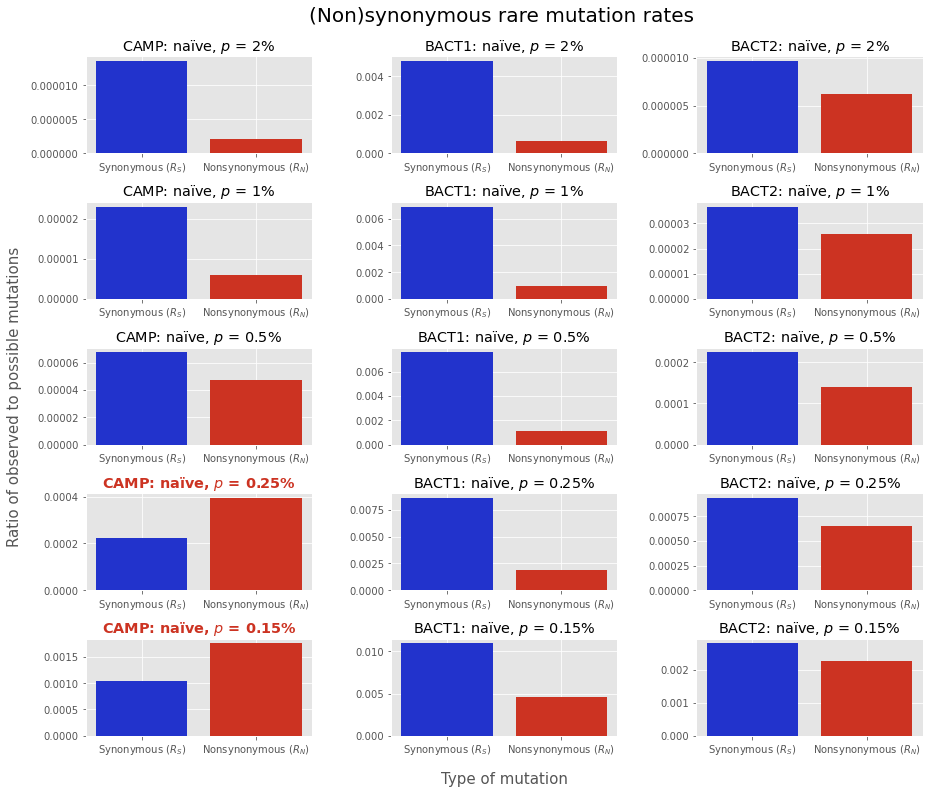

In [73]:
fig, axes = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

if len(percentages) % 2 == 0:
    # Really, the precise middle is between two rows, right? anyway as of writing we use 7 percentages
    # so this never happens
    middle_row = len(percentages) / 2
else:
    middle_row = percentages.index(median(percentages))

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rs = p2seq2obs_si[p][seq] / seq2poss_si[seq]
        rn = p2seq2obs_ni[p][seq] / seq2poss_ni[seq]
        axes[pi, si].bar(
            ["Synonymous ($R_S$)", "Nonsynonymous ($R_N$)"],
            [rs,rn],
            color=["#2233cc", "#cc3322"]
        )
        axes[pi, si].ticklabel_format(axis="y", style="plain")
        
        titlecolor="#000000"
        titleweight="normal"
        if rs <= rn:
            titlecolor = "#cc3322"
            titleweight = "semibold"
            
        axes[pi, si].set_title(f"{seq2name[seq]}: na\u00efve, $p$ = {p}%", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)

axes[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig.suptitle("(Non)synonymous rare mutation rates", y=0.935, x=0.51, fontsize=20)
fig.set_size_inches(15, 12.5)
fig.savefig("figs/syn-nonsyn-barplots.png", bbox_inches="tight")

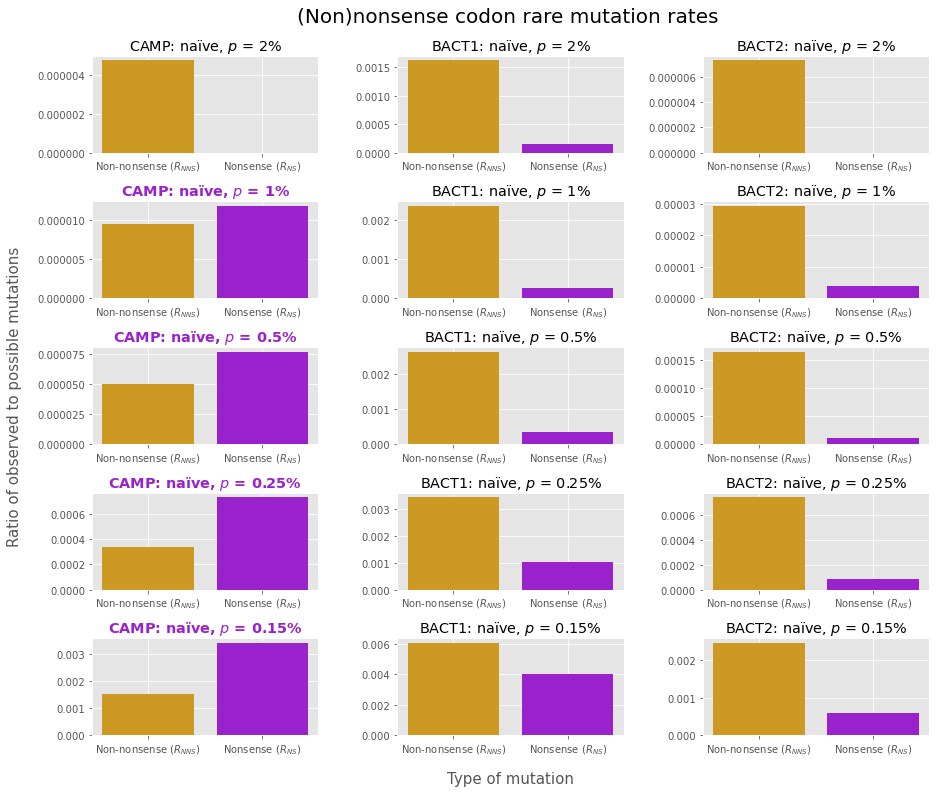

In [74]:
fig, axes = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rnns = p2seq2obs_nnsi[p][seq] / seq2poss_nnsi[seq]
        rns = p2seq2obs_nsi[p][seq] / seq2poss_nsi[seq]
        axes[pi, si].bar(
            ["Non-nonsense ($R_{NNS}$)", "Nonsense ($R_{NS}$)"],
            [rnns, rns],
            color=["#cc9922", "#9922cc"]
        )
        
        # Turn off scientific notation on the y-axis' ticks -- for some very small numbers
        # for CAMP's mutation rates, matplotlib will default to scaling the y-axis tick values by 1e-5.
        # See https://stackoverflow.com/a/28373421: the axis="y" argument is needed because by default
        # this'll try to apply this to *both* axes, and the categorical x-axis causes an error.
        axes[pi, si].ticklabel_format(axis="y", style="plain")
        
        titlecolor = "#000000"
        titleweight = "normal"
        if rnns <= rns:
            titlecolor = "#9922cc"
            titleweight = "semibold"
            
        axes[pi, si].set_title(f"{seq2name[seq]}: na\u00efve, $p$ = {p}%", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)
        
axes[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig.suptitle("(Non)nonsense codon rare mutation rates", y=0.935, x=0.51, fontsize=20)
fig.set_size_inches(15, 12.5)
fig.savefig("figs/nonnonsense-nonsense-barplots.png", bbox_inches="tight")